## PRÁCTICA FINAL MACHINE LEARNING - QIE LIZHANG (AirBnB)

Se busca crear un evaluador automático de precios a partir de las carácterísticas de los alojamientos. 

## 1. PREPROCESSING

In [ ]:
#Cargamos las librerias:

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.impute import KNNImputer
import scipy.stats as ss

sns.set()
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['savefig.bbox'] = "tight"

In [94]:
data = pd.read_csv('airbnb-listings-extract (2).csv',sep=';',encoding='latin-1')

In [95]:
data.head()

,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,...,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,11210388,https://www.airbnb.com/rooms/11210388,20170306202425,2017-03-07,The Loft-Full Bath-Deck w/View,Loft in the Hill country 12-15 minutes directl...,This loft has a spectacular view of the hills ...,Loft in the Hill country 12-15 minutes directl...,none,This neighborhood is located in the hills west...,...,10.0,10.0,10.0,NaN,NaN,moderate,1.0,3.50,"30.3373609355,-97.8632766782","Host Is Superhost,Host Has Profile Pic,Host Id..."
1,17471131,https://www.airbnb.com/rooms/17471131,20170407214050,2017-04-08,"Claris I, Friendly Rentals","This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...",none,Plaza CataluÃ±a Catalonia Square is the larg...,...,10.0,8.0,10.0,HUTB-006721,NaN,super_strict_30,106.0,0.86,"41.3896829422,2.17262543017","Host Has Profile Pic,Requires License,Instant ..."
2,17584891,https://www.airbnb.com/rooms/17584891,20170407214050,2017-04-08,"Style Terrace Red, Friendly Rentals","This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...",none,Plaza CataluÃ±a Catalonia Square is the larg...,...,NaN,NaN,NaN,HUTB-007527,NaN,super_strict_30,106.0,NaN,"41.3930345489,2.16217327868","Host Has Profile Pic,Requires License,Instant ..."
3,5398030,https://www.airbnb.com/rooms/5398030,20170407214050,2017-04-08,Picasso Suite 1.4 Paseo de Gracia,Live like a local in Barcelona's most chic dis...,You wake up to the sun rising over Barcelona's...,Live like a local in Barcelona's most chic dis...,none,We're right in the heart of the chic L'Eixampl...,...,10.0,10.0,9.0,NaN,NaN,strict,24.0,1.09,"41.3969668101,2.1674178103","Host Has Profile Pic,Host Identity Verified,Re..."
4,18104606,https://www.airbnb.com/rooms/18104606,20170407214050,2017-04-08,Smart City Centre Apartment II,"Unique apartment in vibrant neighborhoods, car...","License: HUTB-005313 Charming apartment, locat...","Unique apartment in vibrant neighborhoods, car...",none,NaN,...,NaN,NaN,NaN,NaN,NaN,flexible,92.0,NaN,"41.3886851936,2.15514963616","Host Has Profile Pic,Host Identity Verified,Is..."


In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14780 entries, 0 to 14779
Data columns (total 89 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              14780 non-null  int64  
 1   Listing Url                     14780 non-null  object 
 2   Scrape ID                       14780 non-null  int64  
 3   Last Scraped                    14780 non-null  object 
 4   Name                            14779 non-null  object 
 5   Summary                         14189 non-null  object 
 6   Space                           10888 non-null  object 
 7   Description                     14774 non-null  object 
 8   Experiences Offered             14780 non-null  object 
 9   Neighborhood Overview           9134 non-null   object 
 10  Notes                           5644 non-null   object 
 11  Transit                         9066 non-null   object 
 12  Access                          

Nuestra base de datos contiene un total de 14,780 registros que recopilan información de 89 variables. Dentro de este conjunto de variables, solo 36 son numéricas, lo cual requiere un análisis para determinar qué hacer con ellas. Es necesario estudiar qué acciones tomar respecto a las variables que están compuestas por cadenas de texto y que no se pueden incluir en la construcción de nuestros modelos.

Eliminamos aquellas variables que, a simple vista, parecen ser irrelevantes para la creación de un evaluador de precios. Muchas de estas variables se eliminan debido a que contienen descripciones extensas en forma de texto, lo cual sería inviable trasladar a un modelo predictivo. También retiramos las variables que contienen información relacionada con fechas, como "First Review", "Last Review" y "Calendar Last Scraped". Asimismo, descartamos variables como latitud, longitud y geolocalización, ya que consideramos que no son relevantes para nuestro análisis. 

En cuanto a las variables "Square Feet", "Host Acceptance Rate" y "Has Availability", observamos que tienen 598, 39 y 12 observaciones no nulas respectivamente. No tiene sentido imputar sus valores, por lo que las eliminamos del análisis. 

Además, notamos que las variables "Weekly Price" y "Monthly Price" también tienen una cantidad significativa de valores nulos. No deseamos que nuestro modelo se entrene con variables que contengan la misma información que nuestra variable objetivo (Price). Por lo tanto, esperaremos a calcular la matriz de correlaciones antes de decidir si las eliminamos del conjunto de datos.

In [97]:
data=data.drop(data.columns[[0,1,2,3,4,5,6,7,9,10,11,12,13,14,15,16,17,18,
                             19,20,21,23,24,27,28,29,30,34,35,36,37,40,43,
                             45,55,46,66,71,73,74,82,83,87,88]] , axis=1)

In [98]:
#volvemos a cargar nuestra base de datos después de eliminar 44 variables 
data.head()

,Experiences Offered,Host Since,Host Response Time,Host Response Rate,Host Listings Count,Host Total Listings Count,Host Verifications,City,State,Market,...,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Cancellation Policy,Calculated host listings count,Reviews per Month
0,none,2016-02-11,within an hour,100.0,1.0,1.0,"email,phone,reviews,kba",Austin,TX,Austin,...,98.0,10.0,10.0,10.0,10.0,10.0,10.0,moderate,1.0,3.50
1,none,2016-11-08,within an hour,100.0,162.0,162.0,"email,phone,reviews,work_email",Barcelona,Barcelona,Barcelona,...,80.0,8.0,10.0,10.0,10.0,8.0,10.0,super_strict_30,106.0,0.86
2,none,2016-11-08,within an hour,100.0,162.0,162.0,"email,phone,reviews,work_email",Barcelona,Barcelona,Barcelona,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,super_strict_30,106.0,NaN
3,none,2010-05-25,within an hour,100.0,27.0,27.0,"email,phone,facebook,reviews,manual_offline,ju...",Barcelona,Barcelona,Barcelona,...,92.0,10.0,9.0,10.0,10.0,10.0,9.0,strict,24.0,1.09
4,none,2016-01-12,within an hour,99.0,207.0,207.0,"email,phone,reviews,jumio",Barcelona,Catalunya,Barcelona,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,flexible,92.0,NaN


In [99]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14780 entries, 0 to 14779
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Experiences Offered             14780 non-null  object 
 1   Host Since                      14777 non-null  object 
 2   Host Response Time              12881 non-null  object 
 3   Host Response Rate              12881 non-null  float64
 4   Host Listings Count             14777 non-null  float64
 5   Host Total Listings Count       14777 non-null  float64
 6   Host Verifications              14774 non-null  object 
 7   City                            14774 non-null  object 
 8   State                           14636 non-null  object 
 9   Market                          14723 non-null  object 
 10  Smart Location                  14780 non-null  object 
 11  Country                         14779 non-null  object 
 12  Property Type                   

Después de realizar una limpieza inicial, nuestro conjunto de datos se ha reducido a 45 variables. De estas, 15 todavía no son numéricas. En un próximo paso, evaluaremos si es posible categorizarlas o si su composición requiere eliminarlas del análisis.



In [100]:
#examinamos la distribución de las variables 
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Host Response Rate,12881.0,94.823461,15.215988,0.00,100.00,100.0,100.00,100.00
Host Listings Count,14777.0,12.513636,34.090223,0.00,1.00,2.0,6.00,519.00
Host Total Listings Count,14777.0,12.513636,34.090223,0.00,1.00,2.0,6.00,519.00
Accommodates,14780.0,3.277808,2.097291,1.00,2.00,3.0,4.00,16.00
Bathrooms,14725.0,1.281732,0.658517,0.00,1.00,1.0,1.00,8.00
Bedrooms,14755.0,1.343816,0.900078,0.00,1.00,1.0,2.00,10.00
Beds,14731.0,2.044260,1.612770,1.00,1.00,2.0,2.00,16.00
Price,14763.0,73.561471,72.062050,9.00,34.00,55.0,86.00,999.00
Weekly Price,3590.0,376.937883,195.701043,70.00,215.00,350.0,500.00,999.00
Monthly Price,3561.0,1426.125246,1246.403853,250.00,720.00,1200.0,1725.00,25000.00


In [101]:
#vamos a mirar los valores nulos y después decidiremos como tratarlos 
data.isna().sum()

Experiences Offered                   0
Host Since                            3
Host Response Time                 1899
Host Response Rate                 1899
Host Listings Count                   3
Host Total Listings Count             3
Host Verifications                    6
City                                  6
State                               144
Market                               57
Smart Location                        0
Country                               1
Property Type                         0
Room Type                             0
Accommodates                          0
Bathrooms                            55
Bedrooms                             25
Beds                                 49
Bed Type                              0
Amenities                           170
Price                                17
Weekly Price                      11190
Monthly Price                     11219
Security Deposit                   8524
Cleaning Fee                       6093


In [102]:
#vamos a ver qué variables son categóricas 
data.nunique()

Experiences Offered                   5
Host Since                         2116
Host Response Time                    4
Host Response Rate                   70
Host Listings Count                  56
Host Total Listings Count            56
Host Verifications                  206
City                                246
State                               102
Market                               43
Smart Location                      257
Country                              17
Property Type                        22
Room Type                             3
Accommodates                         16
Bathrooms                            17
Bedrooms                             10
Beds                                 16
Bed Type                              5
Amenities                         12379
Price                               370
Weekly Price                        388
Monthly Price                       586
Security Deposit                    124
Cleaning Fee                        111


Procedemos a  analizar en mayor profundidad las variables "City", "State", "Market" y "Smart Location" para decidir qué hacer con ellas.

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 135 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 142 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 135 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 140 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 142 missing from current font.
  f

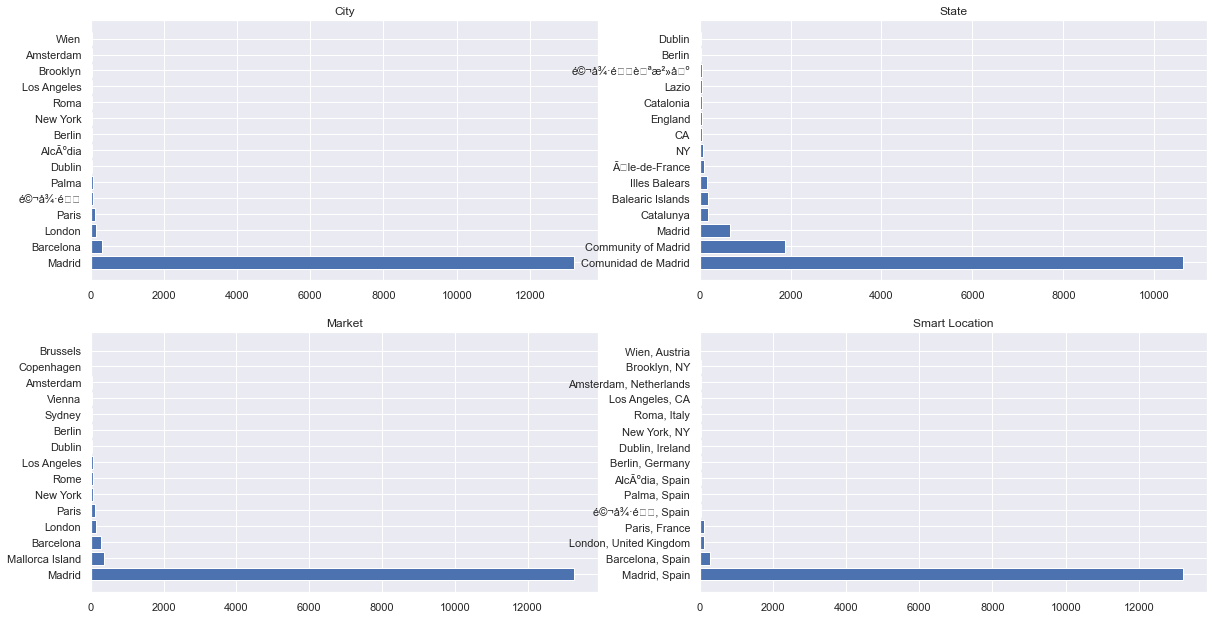

In [103]:
plt.figure(figsize=(20, 22))

plt.subplot(4, 2, 1)
plt.barh(data['City'].value_counts()[:15].index, data['City'].value_counts()[:15])
plt.gca().set_title('City')

plt.subplot(4, 2, 2)
plt.barh(data['State'].value_counts()[:15].index, data['State'].value_counts()[:15])
plt.gca().set_title('State')

plt.subplot(4, 2, 3)
plt.barh(data['Market'].value_counts()[:15].index, data['Market'].value_counts()[:15])
plt.gca().set_title('Market')

plt.subplot(4, 2, 4)
plt.barh(data['Smart Location'].value_counts()[:15].index, data['Smart Location'].value_counts()[:15])
plt.gca().set_title('Smart Location')

plt.show()

Se presentan problemas de estructura en el conjunto de datos. Se observa que algunas ciudades se encuentran registradas de forma distinta, como es el caso de Madrid o Palma, lo que genera duplicados. Además, se nota un desequilibrio significativo en todas las variables debido a la concentración de alojamientos en Madrid. Estos problemas se evidencian claramente en la variable "State", donde las tres categorías con más observaciones son "Comunidad de Madrid", "Community of Madrid" y "Madrid".

Decidiremos conservar únicamente la variable "City", ya que solo tiene 6 valores nulos y no presenta el problema de repetición de localizaciones registradas con diferentes nombres. Sin embargo, debido a la gran cantidad de valores distintos en la variable "City" y al desequilibrio causado por Madrid, no consideramos que se incluya en ningún modelo. Su función será principalmente descriptiva.

In [104]:
data=data.drop(['State','Market','Smart Location'],axis=1)

Vamos a hacer una representación de las variables tanto categóricas como continuas 

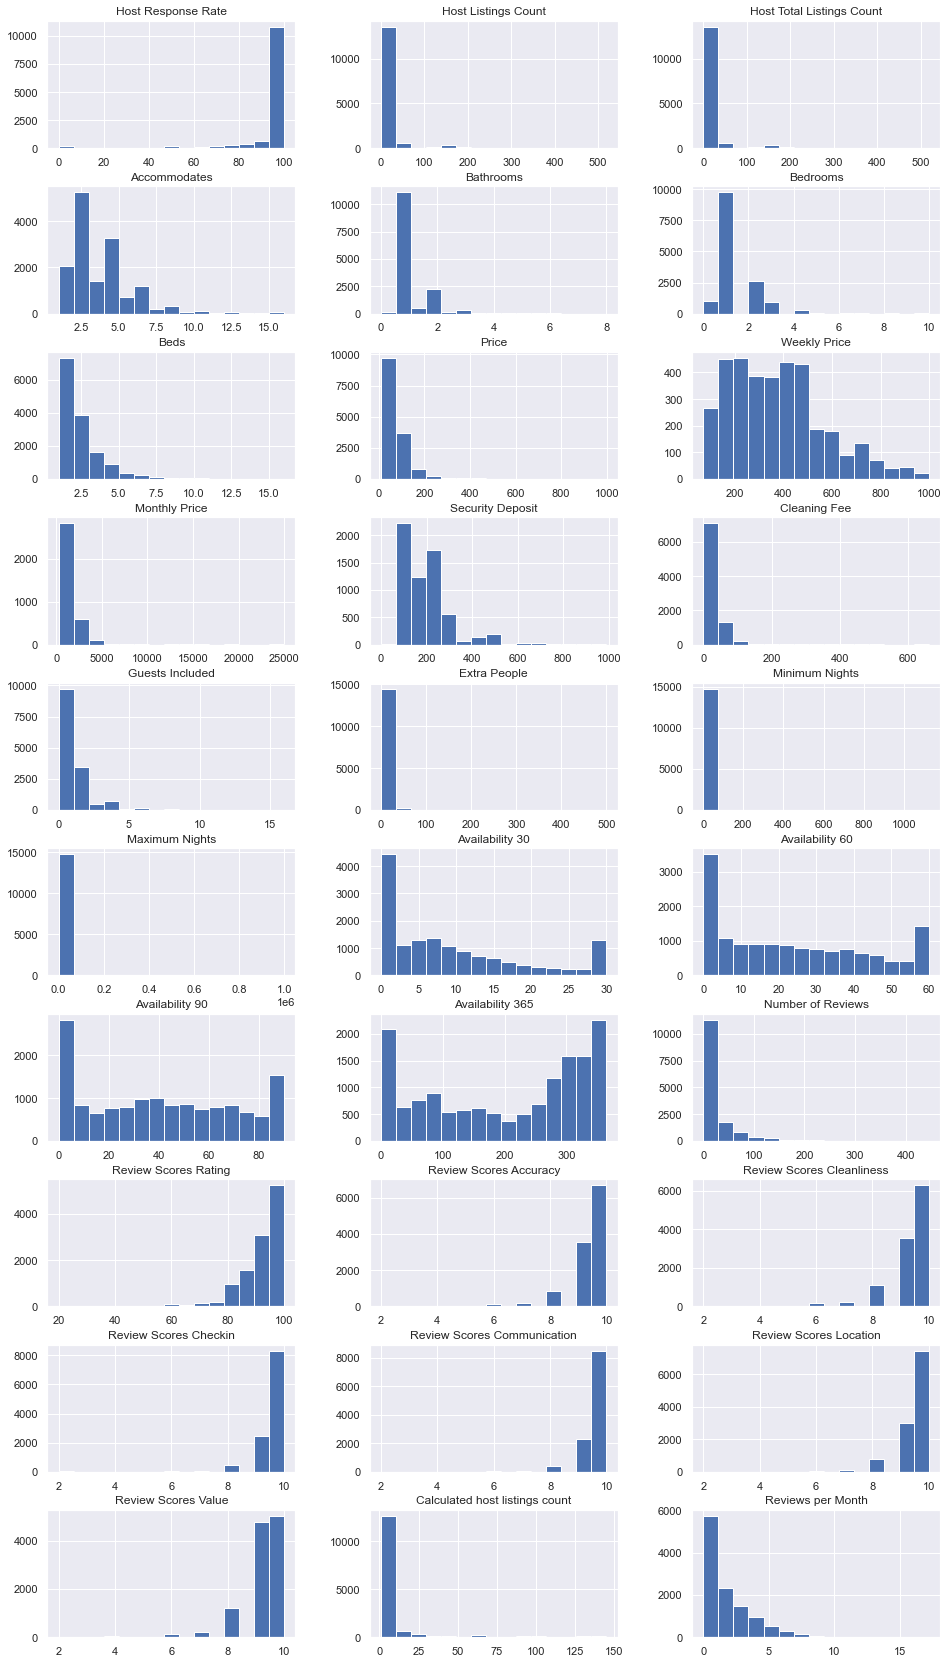

In [105]:
data.hist(figsize=(16,48),layout=(16,3),bins=15) 
plt.show()

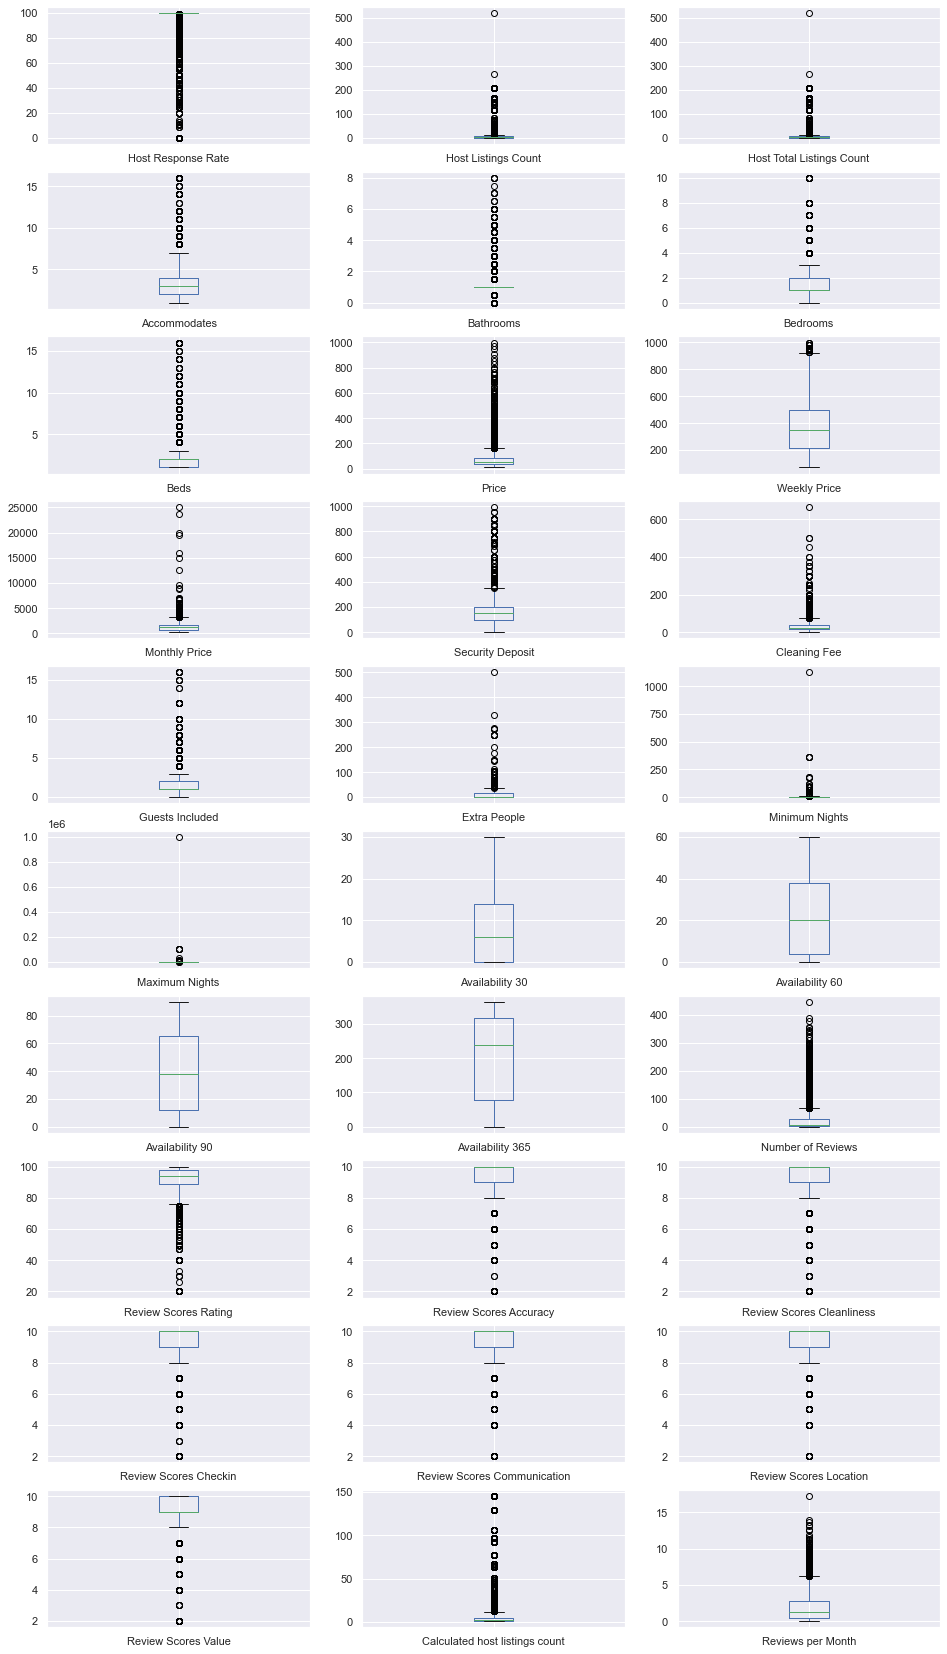

In [106]:
data.plot(figsize=(16,48),kind='box', subplots=True,layout=(16,3),sharex=False, sharey=False)
plt.show()

Como podemos observar, hay outliers, vamos a analizarlos en profundidad

<AxesSubplot:xlabel='Maximum Nights'>

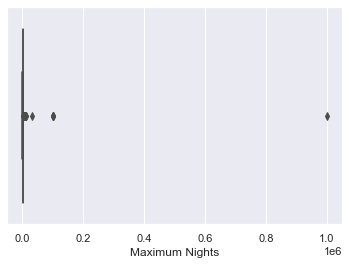

In [107]:
#Maximum Nights 
sns.boxplot(x=data['Maximum Nights'])

In [108]:
data['Maximum Nights'].max()

1000000

Eliminaremos el valor atípico debido a su potencial influencia en la construcción de los modelos.

Se identifican tres valores atípicos claros en la variable "Maximum Nights": uno con un valor de 1,000,000, otro de 100,000 y otro de 30,000. Estos tres valores son potencialmente muy influyentes en la construcción de los modelos y representan datos absurdos, ya que implican períodos de tiempo ilógicos para evaluar la duración de la estadía de los clientes (70 años equivalen a 25,550 días).

In [109]:
data = data[(data['Maximum Nights']<29999)]

<AxesSubplot:xlabel='Maximum Nights'>

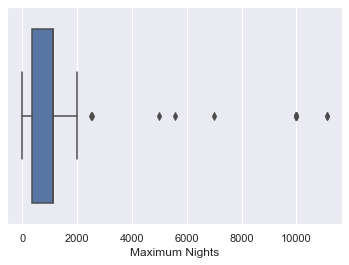

In [110]:
sns.boxplot(x=data['Maximum Nights'])

sigue habiendo outliers pero no tienen tanto peso como los que hemos retirado

<AxesSubplot:xlabel='Minimum Nights'>

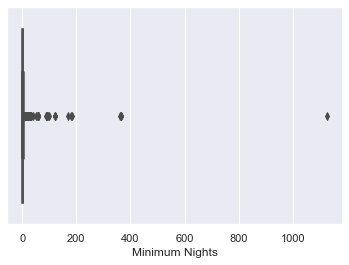

In [111]:
#Minimum Nights
sns.boxplot(x=data['Minimum Nights'])

In [112]:
data['Minimum Nights'].max()

1125

vamos a retirar el que es evidente y volvemos a analizar

In [113]:
data = data[(data['Minimum Nights']<1124)]

<AxesSubplot:xlabel='Minimum Nights'>

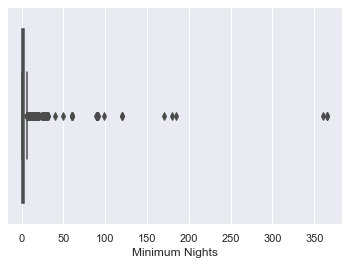

In [114]:
sns.boxplot(x=data['Minimum Nights'])

como podemos observar en esta última gráfica, sigue habiendo dos outliers que son significativos, los retiramos y volvemos a analizar como hemos procedido anteriormente

In [115]:
data = data[(data['Minimum Nights']<300)]

<AxesSubplot:xlabel='Minimum Nights'>

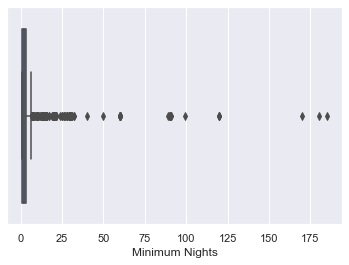

In [116]:
sns.boxplot(x=data['Minimum Nights'])

Aún persiste un gran número de valores atípicos en la variable. No eliminaremos más, ya que esto se debe a que la mayoría de los alojamientos tienen una estancia mínima de 3 días como máximo (el tercer cuartil es de 3 días). Esto provoca que, al representar los datos en un diagrama de caja y bigotes (boxplot), todas las observaciones que tengan valores en "Minimum Nights" que sean 1.5 veces mayores que el rango intercuartílico se consideren valores atípicos.

Después de analizar las variables "Minimum Nights" y "Maximum Nights", consideramos que podría ser interesante realizar un análisis de precios exclusivamente para los alojamientos con estancias cortas. En futuras etapas, se probará la construcción de modelos específicamente para este grupo de datos.

Vamos a analizar las variables categóricas

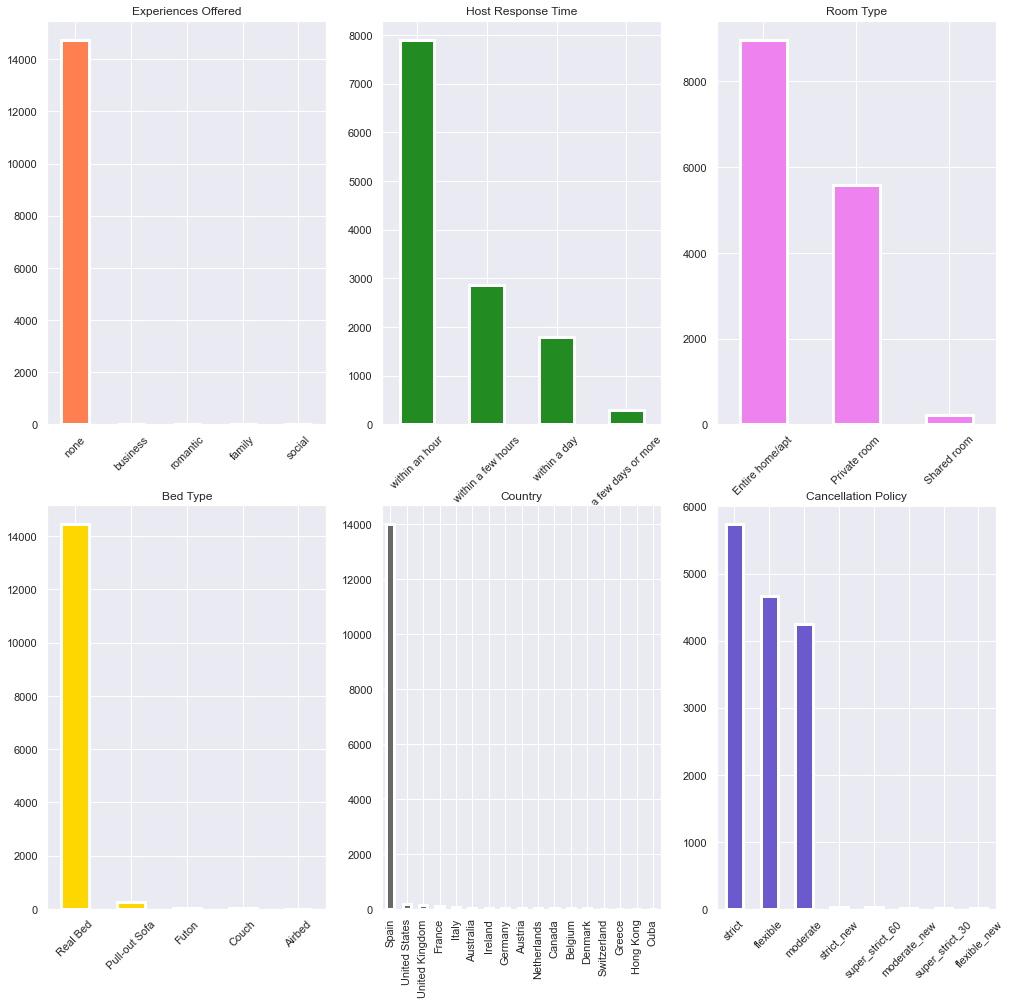

In [117]:
plt.figure(figsize=(17, 52))

plt.subplot(6, 3, 1)
data['Experiences Offered'].value_counts().plot(kind='bar',color = 'coral',linewidth = 3,title='Experiences Offered')
plt.xticks(rotation = 45) 

plt.subplot(6, 3, 2)
data['Host Response Time'].value_counts().plot(kind='bar',color = 'forestgreen',linewidth = 3,title='Host Response Time')
plt.xticks(rotation = 45) 

plt.subplot(6, 3, 3)
data['Room Type'].value_counts().plot(kind='bar',color = 'violet',linewidth = 3,title='Room Type')
plt.xticks(rotation = 45) 

plt.subplot(6, 3, 4)
data['Bed Type'].value_counts().plot(kind='bar',color = 'gold',linewidth = 3,title='Bed Type')
plt.xticks(rotation = 45) 

plt.subplot(6, 3, 5)
data['Country'].value_counts().plot(kind='bar',color = 'dimgray',linewidth = 3,title='Country')

plt.subplot(6, 3, 6)
data['Cancellation Policy'].value_counts().plot(kind='bar',color = 'slateblue',linewidth = 3,title='Cancellation Policy')
plt.xticks(rotation = 45) 

plt.show()

In [118]:
#Experiences Offered
data['Experiences Offered'].value_counts()

none        14751
business        8
romantic        3
family          3
social          3
Name: Experiences Offered, dtype: int64

a penas tiene datos interesantes como para trabajar con ella... la eliminamos 

In [119]:
data=data.drop(['Experiences Offered'],axis=1)

In [120]:
#Bed Type
data['Bed Type'].value_counts()

Real Bed         14444
Pull-out Sofa      258
Futon               42
Couch               19
Airbed               5
Name: Bed Type, dtype: int64

Realizaremos una transformación en la variable "Bed Type", convirtiéndola en una variable dicotómica compuesta por "Real Bed" y "Rest". Sin embargo, será necesario tener precaución al decidir si incluirla o no en los modelos debido al gran desequilibrio que presenta.

La variable "Bed Type" se dividirá en dos categorías: "Real Bed" y "Rest". No obstante, dado que existe un desequilibrio significativo en la distribución de las categorías, se debe tener cuidado al considerar si se incluye esta variable en los modelos posteriores.

In [121]:
data['Bed Type'] = data['Bed Type'].replace(['Pull-out Sofa','Futon', 'Couch','Airbed'],'Rest')  

<AxesSubplot:title={'center':'Bed Type'}>

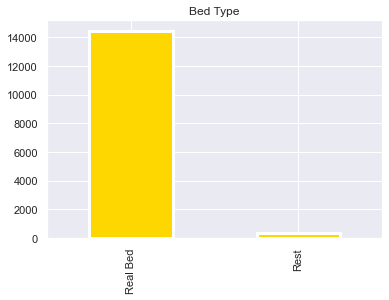

In [122]:
data['Bed Type'].value_counts().plot(kind='bar',color = 'gold',linewidth = 3,title='Bed Type')

In [123]:
#Cancellation Policy
data['Cancellation Policy'].value_counts()

strict             5734
flexible           4669
moderate           4246
strict_new           34
super_strict_60      32
moderate_new         20
super_strict_30      19
flexible_new         14
Name: Cancellation Policy, dtype: int64

In [124]:
#agrupamos para reducir el nº de variables 
data['Cancellation Policy'] = data['Cancellation Policy'].replace(['strict_new','super_strict_60','super_strict_30'],'strict')  
data['Cancellation Policy'] = data['Cancellation Policy'].replace(['moderate_new'],'moderate')  
data['Cancellation Policy'] = data['Cancellation Policy'].replace(['flexible_new'],'flexible')  

<AxesSubplot:title={'center':'Cancellation Policy'}>

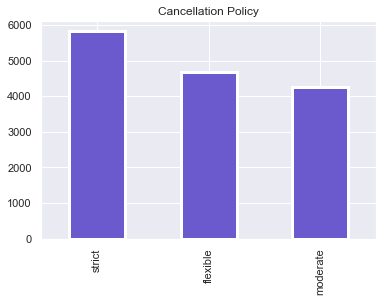

In [125]:
data['Cancellation Policy'].value_counts().plot(kind='bar',color = 'slateblue',linewidth = 3,title='Cancellation Policy')

Por último, vamos a proceder a analizar la variable objetivo "Precio"

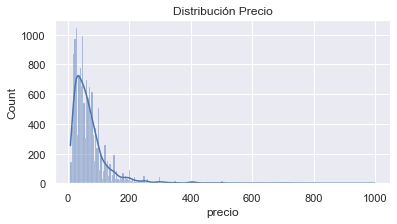

In [126]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
sns.histplot(data=data, x='Price', kde=True,ax=ax)
ax.set_title("Distribución Precio")
ax.set_xlabel('precio');

<AxesSubplot:xlabel='Price'>

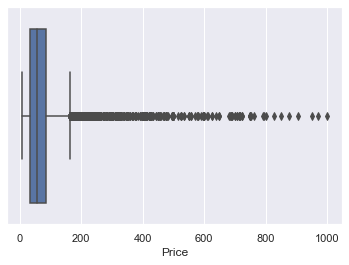

In [127]:
sns.boxplot(x=data['Price'])

In [128]:
data['Price'].describe()

count    14751.000000
mean        73.561792
std         72.065102
min          9.000000
25%         34.000000
50%         55.000000
75%         86.000000
max        999.000000
Name: Price, dtype: float64

En este caso, la variable de precio presenta una distribución asimétrica con una cola positiva, debido a que unos pocos alojamientos en Airbnb tienen precios significativamente superiores a la media. Observamos que la mayoría de los alojamientos tienen precios de estancia por noche que oscilan entre los 30 y 90 euros, y a medida que avanzamos en la distribución, encontramos un alojamiento en el que el costo de hospedarse por un día alcanza los 999 euros.

### Correlaciones

Tanto en los histogramas como en los boxplot, se puede observar cómo Host Listings Count y Host Total Listings Count se distribuyen de la misma forma. Vamos a calcular la correlación entre las variables y así aprovecharemos para estudiar la relación entre todas las variables, y en especial entre estas dos.

<AxesSubplot:>

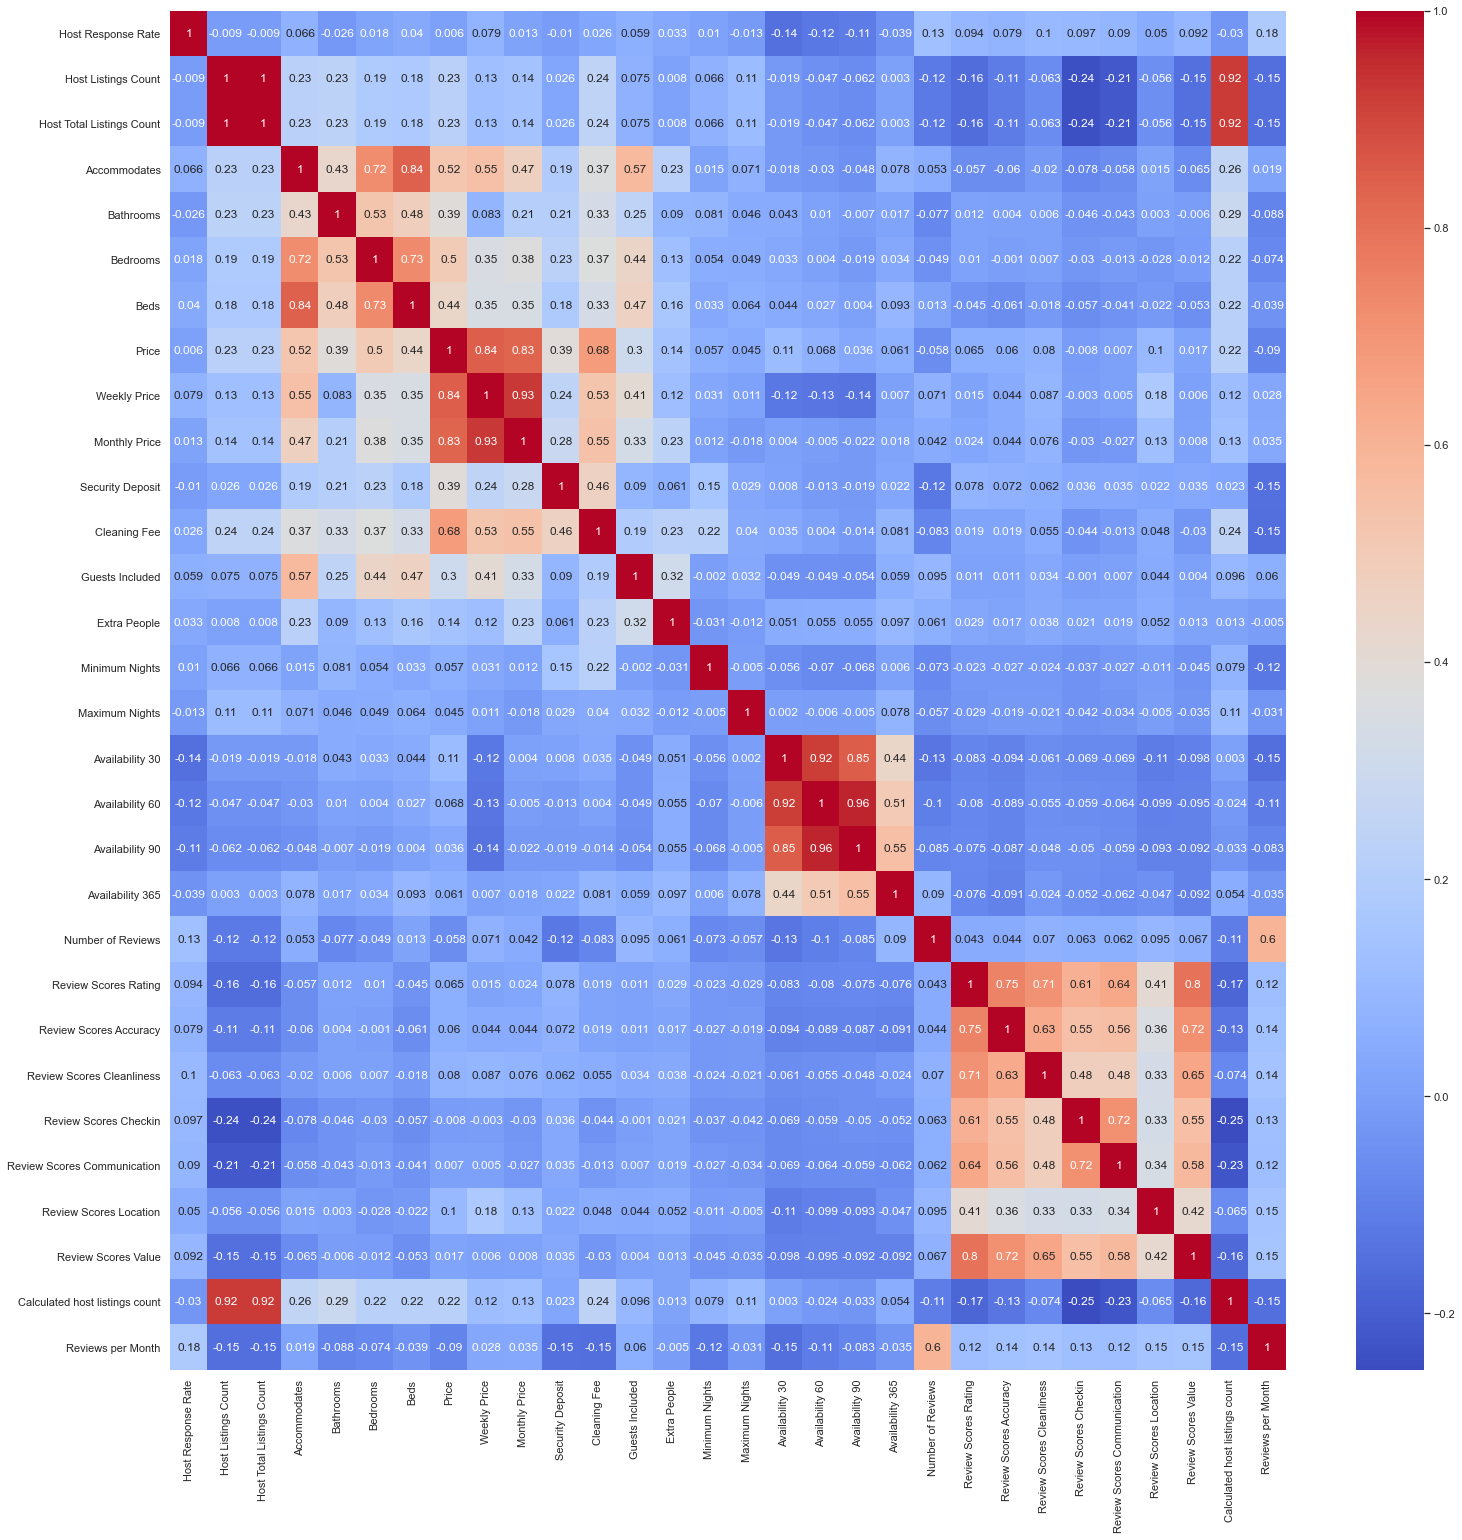

In [129]:
plt.figure(figsize=(25,25))
sns.heatmap(data.corr().round(3),annot=True,cmap='coolwarm')

En efecto, podemos notar que "Host Listings Count" y "Host Total Listings Count" son la misma variable. Además, se observan correlaciones altas entre otras parejas de variables, como "Weekly Price" y "Monthly Price", así como entre "Availability 30", "Availability 60" y "Availability 90". También se aprecia una alta correlación entre "Calculated host listings count" y "Listings Count" y entre "Calculated host listings count" y "Host Total Listings Count".

En consecuencia, hemos eliminado del conjunto de datos las variables "Host Total Listings Count", "Host Listings Count", "Availability 60", "Weekly Price" y "Monthly Price". Ahora procederemos a estudiar en mayor detalle las variables restantes mediante un gráfico de dispersión (scatter plot).

In [130]:
data=data.drop(['Host Total Listings Count','Host Listings Count',
                'Availability 60','Weekly Price','Monthly Price'],axis=1)

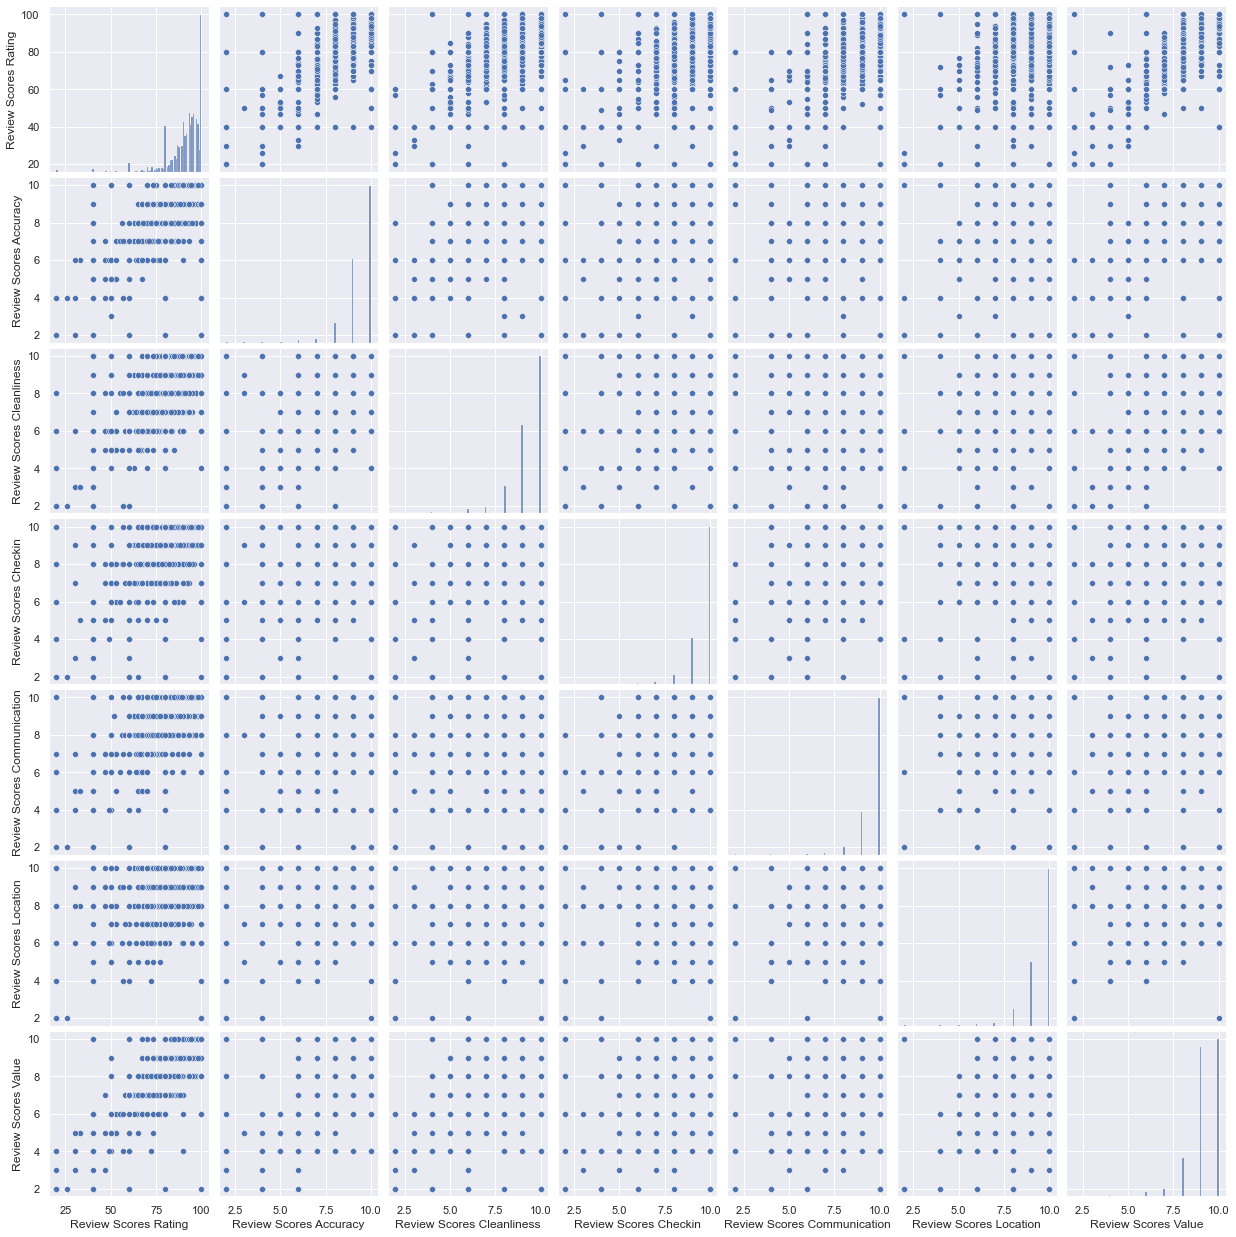

In [131]:
#pairplot de las variables referidas a Review
sns.pairplot(data.loc[:,['Review Scores Rating','Review Scores Accuracy','Review Scores Cleanliness',
                         'Review Scores Checkin', 'Review Scores Communication','Review Scores Location',
                         'Review Scores Value']])

In [132]:
#eliminamos todas las variables excepto Review Scores Rating
data=data.drop(['Review Scores Accuracy','Review Scores Cleanliness',
                'Review Scores Checkin', 'Review Scores Communication',
                'Review Scores Location', 'Review Scores Value'],axis=1)

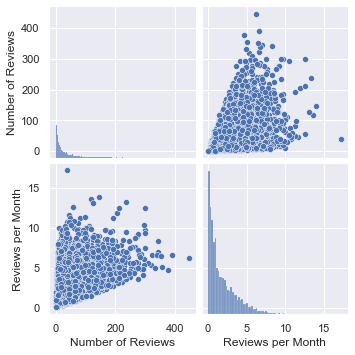

In [133]:
sns.pairplot(data.loc[:,['Number of Reviews','Reviews per Month']])

Observamos una alta homocedasticidad en el gráfico de dispersión entre las variables Number of Reviews y Reviews per Month, pero no vamos a  eliminar ninguna de las dos, pues pueden contener información a la hora de la construcción de los modelos. 

Ahora vamos a representar los gráficos de dispersión del grupo de variables que tienen correlaciones altas con el precio de los alojamientos.

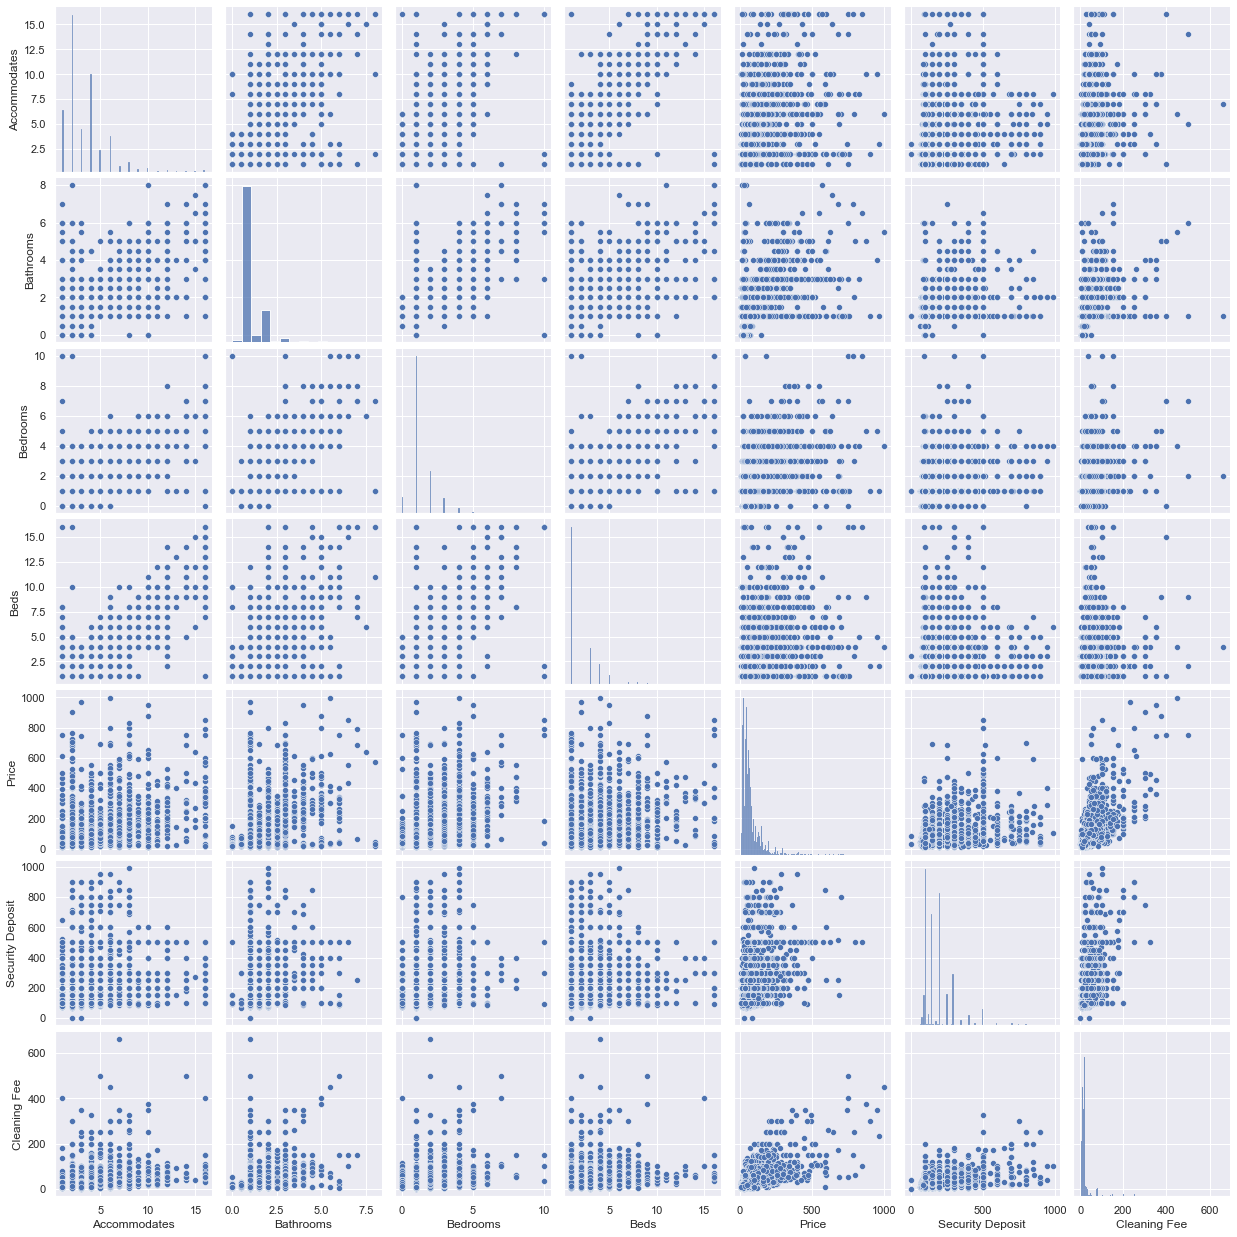

In [134]:
sns.pairplot(data.loc[:,['Accommodates', 'Bathrooms', 'Bedrooms', 'Beds',
                         'Price', 'Security Deposit', 'Cleaning Fee']])

No se observa ninguna relación evidente

## 2. TRANSFORMACIÓN DE VARIABLES E IMPUTACION DE VALORES MISSINGS 

In [135]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14768 entries, 0 to 14779
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Host Since                      14765 non-null  object 
 1   Host Response Time              12874 non-null  object 
 2   Host Response Rate              12874 non-null  float64
 3   Host Verifications              14762 non-null  object 
 4   City                            14762 non-null  object 
 5   Country                         14767 non-null  object 
 6   Property Type                   14768 non-null  object 
 7   Room Type                       14768 non-null  object 
 8   Accommodates                    14768 non-null  int64  
 9   Bathrooms                       14713 non-null  float64
 10  Bedrooms                        14743 non-null  float64
 11  Beds                            14719 non-null  float64
 12  Bed Type                        

Vamos a transformar las variables object en tipo float o int para que no nos den problemas después y las limpiaremos de missings en el caso de que los tenga.

In [136]:
#Host since
data['Host Since']

0        2016-02-11
1        2016-11-08
2        2016-11-08
3        2010-05-25
4        2016-01-12
            ...    
14775    2013-12-18
14776    2017-03-24
14777    2015-07-06
14778    2013-03-20
14779    2014-04-21
Name: Host Since, Length: 14768, dtype: object

Parece que la variable en cuestión es de tipo fecha. Una estrategia adecuada para transformarla en un valor de tipo float sería restarle la fecha actual, utilizando la funcionalidad proporcionada por Python, para obtener así el número de días transcurridos desde que el anfitrión comenzó a ofertar su propiedad en Airbnb. Sin embargo, es importante tener en cuenta que los tres valores faltantes en esta variable pueden generar dificultades en el análisis. Por lo tanto, hemos decidido eliminar dichas observaciones, ya que representan solo un total de 3 registros.

In [137]:
data = data.dropna(subset=['Host Since'])

In [138]:
data['Host Since'].isna().sum()

0

In [139]:
from datetime import date
today = date.today()
for i in data['Host Since']:
    if isinstance(i, str):
        days = (today - date.fromisoformat(i)).days
        data['Host Since'] = data['Host Since'].replace(i,days) 

In [140]:
data['Host Since']

0        2674
1        2403
2        2403
3        4762
4        2704
         ... 
14775    3459
14776    2267
14777    2894
14778    3732
14779    3335
Name: Host Since, Length: 14765, dtype: int64

In [141]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14765 entries, 0 to 14779
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Host Since                      14765 non-null  int64  
 1   Host Response Time              12874 non-null  object 
 2   Host Response Rate              12874 non-null  float64
 3   Host Verifications              14759 non-null  object 
 4   City                            14759 non-null  object 
 5   Country                         14764 non-null  object 
 6   Property Type                   14765 non-null  object 
 7   Room Type                       14765 non-null  object 
 8   Accommodates                    14765 non-null  int64  
 9   Bathrooms                       14710 non-null  float64
 10  Bedrooms                        14740 non-null  float64
 11  Beds                            14716 non-null  float64
 12  Bed Type                        

In [142]:
#Host Response Time
data['Host Response Time']

0            within an hour
1            within an hour
2            within an hour
3            within an hour
4            within an hour
                ...        
14775    within a few hours
14776                   NaN
14777        within an hour
14778    within a few hours
14779        within an hour
Name: Host Response Time, Length: 14765, dtype: object

vamos a transformar la variable de tipo object a int

<AxesSubplot:title={'center':'Host Response Time'}>

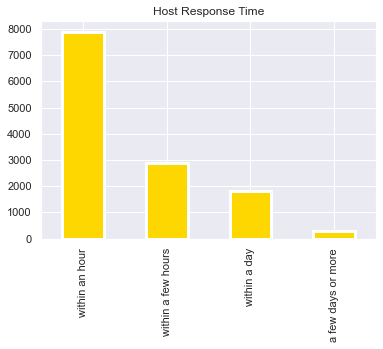

In [143]:
data['Host Response Time'].value_counts().plot(kind='bar',color = 'gold',linewidth = 3,title='Host Response Time')

Para que se asemeje a Host Response Rate, llamaremos a few days or more como 0 e iremos aumentando hasta 3.

In [144]:
data['Host Response Time'] = data['Host Response Time'].replace(['a few days or more'],0) 
data['Host Response Time'] = data['Host Response Time'].replace(['within a day'],1) 
data['Host Response Time'] = data['Host Response Time'].replace(['within a few hours'],2) 
data['Host Response Time'] = data['Host Response Time'].replace(['within an hour'],3) 

In [145]:
data['Host Response Time']

0        3.0
1        3.0
2        3.0
3        3.0
4        3.0
        ... 
14775    2.0
14776    NaN
14777    3.0
14778    2.0
14779    3.0
Name: Host Response Time, Length: 14765, dtype: float64

Antes de imputar los valores faltantes, es importante tener en cuenta dos observaciones:

1. Si una observación tiene un Host Response Rate de 0, entonces también tendrá un Host Response Time de 0. Esto significa que las personas que no responden nunca (Host Response Rate = 0) se clasifican en el grupo "a few days or more" en cuanto al tiempo de respuesta del anfitrión.

2. Se observa que ambas variables, Host Response Rate y Host Response Time, tienen los mismos valores faltantes y, de hecho, coinciden en su ausencia.

Estos hallazgos nos permitirán abordar de manera más precisa la imputación de los valores faltantes en ambas variables.

In [146]:
data[data['Host Response Rate']==0]

,Host Since,Host Response Time,Host Response Rate,Host Verifications,City,Country,Property Type,Room Type,Accommodates,Bathrooms,...,Maximum Nights,Calendar Updated,Availability 30,Availability 90,Availability 365,Number of Reviews,Review Scores Rating,Cancellation Policy,Calculated host listings count,Reviews per Month
69,4760,0.0,0.0,"email,phone,facebook,reviews,jumio",Madrid,Spain,Apartment,Private room,1,2.0,...,1125,2 months ago,0,6,281,0,NaN,flexible,2.0,NaN
82,3521,0.0,0.0,"email,phone,reviews,manual_offline,jumio",Madrid,Spain,Apartment,Entire home/apt,8,1.0,...,1125,today,0,0,82,1,40.0,strict,3.0,0.06
168,3154,0.0,0.0,"email,phone,reviews,manual_offline,jumio",Madrid,Spain,Apartment,Entire home/apt,4,2.0,...,1125,3 weeks ago,2,52,304,17,83.0,strict,1.0,0.57
183,2918,0.0,0.0,"email,phone,reviews,jumio",Madrid,Spain,Apartment,Private room,1,1.0,...,30,2 months ago,28,88,178,3,100.0,moderate,1.0,0.29
189,4011,0.0,0.0,"email,phone,reviews",Madrid,Spain,Apartment,Private room,1,1.5,...,1125,2 days ago,0,7,130,7,93.0,moderate,2.0,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14242,2627,0.0,0.0,"email,phone",Madrid,Spain,Bed & Breakfast,Private room,2,1.0,...,1125,2 months ago,30,90,365,0,NaN,flexible,1.0,NaN
14265,3852,0.0,0.0,"email,phone,facebook,reviews",Madrid,Spain,Apartment,Entire home/apt,4,1.0,...,1125,3 months ago,0,3,278,3,50.0,flexible,2.0,0.20
14588,2698,0.0,0.0,"phone,reviews",Madrid,Spain,Apartment,Private room,1,1.0,...,1125,4 months ago,30,90,365,8,93.0,flexible,1.0,0.56
14634,3017,0.0,0.0,"email,phone,reviews",Madrid,Spain,Apartment,Shared room,1,1.0,...,1125,25 months ago,30,90,365,0,NaN,flexible,1.0,NaN


In [147]:
data['Host Response Time'].isna().sum()==data['Host Response Rate'].isna().sum()

True

In [148]:
data[data['Host Response Rate'].isna()]

,Host Since,Host Response Time,Host Response Rate,Host Verifications,City,Country,Property Type,Room Type,Accommodates,Bathrooms,...,Maximum Nights,Calendar Updated,Availability 30,Availability 90,Availability 365,Number of Reviews,Review Scores Rating,Cancellation Policy,Calculated host listings count,Reviews per Month
11,3459,NaN,NaN,"email,phone,reviews,jumio,work_email",Antwerpen,Belgium,Apartment,Entire home/apt,2,1.0,...,1125,7 months ago,0,33,308,7,97.0,strict,1.0,0.43
22,2543,NaN,NaN,"email,phone,reviews",Barcelona,Spain,Apartment,Entire home/apt,4,2.0,...,1125,8 months ago,0,0,0,1,100.0,moderate,1.0,0.13
34,3360,NaN,NaN,"email,phone,jumio",Barcelona,Spain,Apartment,Entire home/apt,1,1.0,...,1125,2 months ago,30,90,90,1,NaN,flexible,1.0,0.04
36,3322,NaN,NaN,"email,phone,jumio",Amsterdam,Netherlands,Apartment,Private room,2,1.0,...,1125,13 months ago,0,0,0,0,NaN,flexible,1.0,NaN
38,3654,NaN,NaN,"email,phone,reviews,jumio",Paris,France,Apartment,Entire home/apt,6,1.0,...,1125,7 months ago,0,0,0,8,93.0,strict,1.0,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14743,2520,NaN,NaN,phone,Madrid,Spain,Apartment,Private room,1,2.0,...,1125,7 months ago,0,7,282,0,NaN,flexible,1.0,NaN
14760,3507,NaN,NaN,"email,phone,reviews,jumio",Los Angeles,United States,Apartment,Entire home/apt,3,1.0,...,1125,6 months ago,0,0,0,3,93.0,moderate,1.0,0.11
14762,3544,NaN,NaN,"email,phone,reviews",PollenÃ§a,Spain,Apartment,Entire home/apt,6,1.0,...,1125,4 weeks ago,16,16,150,6,88.0,strict,2.0,0.30
14774,4380,NaN,NaN,"email,phone,facebook,reviews,kba",Queens,United States,Apartment,Private room,1,1.0,...,68,11 months ago,0,0,0,1,80.0,moderate,1.0,0.05


Hemos decidido no eliminar las observaciones que contienen valores faltantes y, en su lugar, investigar la razón detrás de la ausencia de estos datos.

En este caso, entendemos que la falta de datos indica que los propietarios no han respondido nunca. Inicialmente, consideramos la posibilidad de crear una nueva variable en "Host Response Time" para reflejar esta situación. Sin embargo, al observar que las personas que no responden prácticamente nunca (Host Response Rate = 0) se clasifican en el grupo de "a few days or more", creemos más apropiado imputar los valores faltantes con 0. De esta manera, incluiremos estas observaciones en el grupo de "a few days or more" en "Host Response Time".

In [149]:
data.fillna({'Host Response Time': 0}, inplace=True)
data.fillna({'Host Response Rate': 0}, inplace=True)

In [150]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14765 entries, 0 to 14779
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Host Since                      14765 non-null  int64  
 1   Host Response Time              14765 non-null  float64
 2   Host Response Rate              14765 non-null  float64
 3   Host Verifications              14759 non-null  object 
 4   City                            14759 non-null  object 
 5   Country                         14764 non-null  object 
 6   Property Type                   14765 non-null  object 
 7   Room Type                       14765 non-null  object 
 8   Accommodates                    14765 non-null  int64  
 9   Bathrooms                       14710 non-null  float64
 10  Bedrooms                        14740 non-null  float64
 11  Beds                            14716 non-null  float64
 12  Bed Type                        

In [151]:
#host verifications 
list(data['Host Verifications'].head(10))

['email,phone,reviews,kba',
 'email,phone,reviews,work_email',
 'email,phone,reviews,work_email',
 'email,phone,facebook,reviews,manual_offline,jumio,work_email',
 'email,phone,reviews,jumio',
 'email,phone,reviews,jumio',
 'email,phone,reviews',
 'email,phone,facebook,reviews',
 'email,phone,reviews,jumio',
 'email,phone,reviews,kba']

Antes de tomar cualquier acción, es importante observar que los valores nulos en las verificaciones de host pueden tener un significado. En este caso, los valores nulos indican que no hay ninguna verificación realizada por los anfitriones. Es crucial tener en cuenta que todos los datos están representados por cadenas de caracteres no vacías. Es muy probable que, si una cadena está vacía, Airbnb la haya clasificado como un valor faltante.

Por lo tanto, debemos tener cuidado al tratar con los seis valores nulos en las verificaciones de host, ya que incluso siendo pocos, podrían contener información relevante. No se recomienda eliminar estos valores nulos.

Una idea para transformar estas cadenas de caracteres en tipo entero. Observamos que podemos obtener la misma información de esta variable si contamos la cantidad de métodos que el propietario ofrece para ser contactado. Podemos separar astutamente las observaciones utilizando el método "split" y luego contarlos. De esta manera, logramos alcanzar nuestro objetivo de convertir los datos en tipo entero.

In [152]:
# Un ejemplo
ejemplo = data['Host Verifications'][0].split(sep=',')
print ('El propietario es contactable mediante ', ejemplo, 'tiene ', len(ejemplo), 'formas disponibles de contactar con él')

El propietario es contactable mediante  ['email', 'phone', 'reviews', 'kba'] tiene  4 formas disponibles de contactar con él


In [153]:
data.fillna({'Host Verifications': 0}, inplace=True)
for i in data['Host Verifications']:
    if isinstance(i, str):
        data['Host Verifications'] = data['Host Verifications'].replace(i,len(i.split(sep=','))) 

In [154]:
data['Host Verifications']

0        4
1        4
2        4
3        7
4        4
        ..
14775    4
14776    2
14777    4
14778    6
14779    7
Name: Host Verifications, Length: 14765, dtype: int64

Le hemos dado el valor 0 a todos los missings que hemos encontrado en los datos

#### City, Country, Property Type, Room Type y Bed Type


Para imputar el único missing de Country basta buscar cual es y añadir en country su valor correcto.

In [155]:
data[data['Country'].isna()]

,Host Since,Host Response Time,Host Response Rate,Host Verifications,City,Country,Property Type,Room Type,Accommodates,Bathrooms,...,Maximum Nights,Calendar Updated,Availability 30,Availability 90,Availability 365,Number of Reviews,Review Scores Rating,Cancellation Policy,Calculated host listings count,Reviews per Month
151,3580,0.0,0.0,2,Salerno,NaN,House,Private room,1,1.0,...,1125,31 months ago,30,90,365,0,NaN,flexible,1.0,NaN


In [156]:
#imputamos Salerno 
data.loc[151,'Country']='Italy'

La variable "City" presenta una complejidad adicional, ya que todos los apartamentos con valores faltantes se encuentran en España. Una posible opción sería imputar los valores faltantes utilizando la moda de los apartamentos ubicados en España. Sin embargo, esta aproximación podría llevar a cometer errores, ya que no tenemos garantía de que sea la elección correcta.

Dado que solo hay 6 observaciones con valores faltantes, consideramos que la opción más adecuada es eliminar estas observaciones. Al eliminarlas, evitamos posibles problemas y aseguramos la integridad de los datos restantes.

In [157]:
data = data.dropna(subset=['City'])

In [158]:
data.isna().sum()

Host Since                           0
Host Response Time                   0
Host Response Rate                   0
Host Verifications                   0
City                                 0
Country                              0
Property Type                        0
Room Type                            0
Accommodates                         0
Bathrooms                           55
Bedrooms                            25
Beds                                49
Bed Type                             0
Amenities                          165
Price                               17
Security Deposit                  8509
Cleaning Fee                      6082
Guests Included                      0
Extra People                         0
Minimum Nights                       0
Maximum Nights                       0
Calendar Updated                     0
Availability 30                      0
Availability 90                      0
Availability 365                     0
Number of Reviews        

Ya están limpias de datos missings, pero siguen siendo tipo object. Utilizaremos Label Encoder para transformarlas. Que les asigna un entero según el orden alfabetico.

In [159]:
from sklearn.preprocessing import LabelEncoder

LE=LabelEncoder()
for i in data.iloc[:,[4,5,6,7,12]]:
    data[i]=data[[i]].apply(LE.fit_transform)

In [160]:
data.head(10)

,Host Since,Host Response Time,Host Response Rate,Host Verifications,City,Country,Property Type,Room Type,Accommodates,Bathrooms,...,Maximum Nights,Calendar Updated,Availability 30,Availability 90,Availability 365,Number of Reviews,Review Scores Rating,Cancellation Policy,Calculated host listings count,Reviews per Month
0,2674,3.0,100.0,4,13,16,15,0,2,1.0,...,1125,today,10,64,281,42,98.0,moderate,1.0,3.50
1,2403,3.0,100.0,4,16,13,0,0,4,1.0,...,1125,today,6,39,309,1,80.0,strict,106.0,0.86
2,2403,3.0,100.0,4,16,13,0,0,4,1.0,...,1125,today,7,42,291,0,NaN,strict,106.0,NaN
3,4762,3.0,100.0,7,16,13,0,0,8,2.0,...,1125,today,11,47,316,13,92.0,strict,24.0,1.09
4,2704,3.0,99.0,4,16,13,0,0,5,1.0,...,1125,today,0,0,7,0,NaN,flexible,92.0,NaN
5,2704,3.0,99.0,4,16,13,0,0,6,1.0,...,1125,2 weeks ago,0,2,4,0,NaN,strict,92.0,NaN
6,3638,1.0,100.0,3,16,13,0,0,5,2.0,...,365,today,4,23,280,43,90.0,strict,1.0,1.22
7,3990,3.0,100.0,4,16,13,0,1,2,1.0,...,7,yesterday,13,66,66,29,96.0,flexible,1.0,0.64
8,2704,3.0,99.0,4,16,13,0,0,6,2.0,...,1125,a week ago,0,2,2,1,80.0,strict,92.0,0.33
9,2985,2.0,100.0,4,13,16,14,0,6,2.0,...,1125,today,21,81,356,1,100.0,strict,1.0,0.06


#### Bathrooms, Bedrooms y Beds

Estas variables ya están en formato float, lo cual es excelente. Sin embargo, contienen valores faltantes. Podríamos haber asumido que esos valores faltantes indican que el apartamento no tiene alguna de esas características. Sin embargo, al verificar los datos, nos damos cuenta de que hay muchos apartamentos con valores faltantes en estas variables.

En vista de esta información, no podemos concluir de manera definitiva que los valores faltantes representen la ausencia de esas características. Por lo tanto, es importante tener precaución antes de tomar decisiones basadas en esta suposición.

Se recomienda explorar más a fondo los datos y considerar otras opciones para tratar con los valores faltantes en estas variables.

In [161]:
(data.Bedrooms==0).sum()+(data.Bathrooms==0).sum()+(data.Beds==0).sum()

1067

Dado que hay tan pocos valores faltantes, es probable que se haya producido un error al recopilar esa información en la base de datos. Para abordar esta situación, utilizaremos el método KNNimputer para asignar valores adecuados a los missings. En este caso, seleccionaremos como vecinos el 0.001% de las observaciones totales, lo que equivale a 15 vecinos. Además, redondearemos los resultados a las unidades, ya que los valores reales son números enteros.

La elección del método KNNimputer es más interesante y elegante que simplemente imputar los valores por la mediana. Además, al utilizar KNNimputer, respetamos mejor la forma de la distribución de los datos, evitando posibles problemas de leptocurtosis.

In [162]:
knn = KNNImputer(n_neighbors=15)
data["Bathrooms"] = np.around(knn.fit_transform(data["Bathrooms"].values.reshape(-1, 1)),decimals=0)
data["Bedrooms"] = np.around(knn.fit_transform(data["Bedrooms"].values.reshape(-1, 1)),decimals=0)
data["Beds"] = np.around(knn.fit_transform(data["Beds"].values.reshape(-1, 1)),decimals=0)

In [163]:
data.isna().sum()

Host Since                           0
Host Response Time                   0
Host Response Rate                   0
Host Verifications                   0
City                                 0
Country                              0
Property Type                        0
Room Type                            0
Accommodates                         0
Bathrooms                            0
Bedrooms                             0
Beds                                 0
Bed Type                             0
Amenities                          165
Price                               17
Security Deposit                  8509
Cleaning Fee                      6082
Guests Included                      0
Extra People                         0
Minimum Nights                       0
Maximum Nights                       0
Calendar Updated                     0
Availability 30                      0
Availability 90                      0
Availability 365                     0
Number of Reviews        

#### Amenities

Nos encontramos nuevamente con el mismo problema que enfrentamos al tratar los datos de "Host Verifications" al lidiar con la variable "amenities". Los elementos en esta variable son cadenas de caracteres, y mientras más comodidades haya, mejor será. Abordaremos este problema de la misma manera que antes.

Además, observamos que hay 165 valores faltantes en "amenities", lo cual indica que esos apartamentos tienen una lista vacía de comodidades. Por lo tanto, imputaremos esos valores faltantes por 0, indicando la ausencia de comodidades.

Al imputar los valores faltantes por 0, debemos asegurarnos de que los datos sean tratados como números enteros.



In [164]:
data['Amenities']

0        TV,Cable TV,Internet,Wireless Internet,Air con...
1        Wireless Internet,Air conditioning,Elevator in...
2        Wireless Internet,Air conditioning,Elevator in...
3        TV,Internet,Wireless Internet,Air conditioning...
4        TV,Wireless Internet,Air conditioning,Kitchen,...
                               ...                        
14775    TV,Cable TV,Internet,Wireless Internet,Air con...
14776    TV,Wireless Internet,Kitchen,Breakfast,Elevato...
14777    TV,Cable TV,Internet,Wireless Internet,Air con...
14778    Internet,Wireless Internet,Kitchen,Heating,Was...
14779    TV,Cable TV,Internet,Wireless Internet,Air Con...
Name: Amenities, Length: 14759, dtype: object

In [165]:
data.fillna({'Amenities': 0}, inplace=True)
for i in data['Amenities']:
    if isinstance(i, str):
        data['Amenities'] = data['Amenities'].replace(i,len(i.split(sep=',')))

In [166]:
data['Amenities']

0        23
1         7
2         7
3        24
4        12
         ..
14775    11
14776    11
14777    17
14778    18
14779    21
Name: Amenities, Length: 14759, dtype: int64

In [167]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14759 entries, 0 to 14779
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Host Since                      14759 non-null  int64  
 1   Host Response Time              14759 non-null  float64
 2   Host Response Rate              14759 non-null  float64
 3   Host Verifications              14759 non-null  int64  
 4   City                            14759 non-null  int64  
 5   Country                         14759 non-null  int64  
 6   Property Type                   14759 non-null  int64  
 7   Room Type                       14759 non-null  int64  
 8   Accommodates                    14759 non-null  int64  
 9   Bathrooms                       14759 non-null  float64
 10  Bedrooms                        14759 non-null  float64
 11  Beds                            14759 non-null  float64
 12  Bed Type                        

#### Price

En nuestra variable objetivo podemos permitir missings, además solo hay 17, vamos a eliminarlos

In [168]:
data = data.dropna(subset=['Price'])

In [169]:
data.isna().sum()


Host Since                           0
Host Response Time                   0
Host Response Rate                   0
Host Verifications                   0
City                                 0
Country                              0
Property Type                        0
Room Type                            0
Accommodates                         0
Bathrooms                            0
Bedrooms                             0
Beds                                 0
Bed Type                             0
Amenities                            0
Price                                0
Security Deposit                  8494
Cleaning Fee                      6074
Guests Included                      0
Extra People                         0
Minimum Nights                       0
Maximum Nights                       0
Calendar Updated                     0
Availability 30                      0
Availability 90                      0
Availability 365                     0
Number of Reviews        

#### Security Deposit y Cleaning Fee

Al observar la considerable cantidad de valores faltantes presentes y la estructura de los datos, es evidente que los valores faltantes en estas variables tienen un significado claro: específicamente, que tanto el depósito de seguridad como la tarifa de limpieza son 0. Por lo tanto, procedamos a imputarlos en consecuencia.

In [170]:
data.fillna({'Security Deposit': 0}, inplace=True)
data.fillna({'Cleaning Fee': 0}, inplace=True)

In [171]:
data.isna().sum()

Host Since                           0
Host Response Time                   0
Host Response Rate                   0
Host Verifications                   0
City                                 0
Country                              0
Property Type                        0
Room Type                            0
Accommodates                         0
Bathrooms                            0
Bedrooms                             0
Beds                                 0
Bed Type                             0
Amenities                            0
Price                                0
Security Deposit                     0
Cleaning Fee                         0
Guests Included                      0
Extra People                         0
Minimum Nights                       0
Maximum Nights                       0
Calendar Updated                     0
Availability 30                      0
Availability 90                      0
Availability 365                     0
Number of Reviews        

#### Calendar Updated

Con el fin de transformar esta variable de tipo "object" a "int" y preservar su significado, crearemos un código que tomará la cadena de texto que indica cuánto tiempo ha pasado desde la última actualización del calendario, y devolverá el número de días transcurridos desde entonces.

In [172]:
data['Calendar Updated'].head(20)

0            today
1            today
2            today
3            today
4            today
5      2 weeks ago
6            today
7        yesterday
8       a week ago
9            today
10      a week ago
11    7 months ago
12           today
13     2 weeks ago
14     4 weeks ago
15           today
16      a week ago
17     5 weeks ago
18           today
19      a week ago
Name: Calendar Updated, dtype: object

In [173]:
for i in data['Calendar Updated']:
    if isinstance(i, str):
        if i.split()[0] == 'today':
            data['Calendar Updated'] = data['Calendar Updated'].replace(i,0)
        elif i.split()[0] == 'yesterday':
            data['Calendar Updated'] = data['Calendar Updated'].replace(i,1)
        elif i.split()[0] == 'never':
            data['Calendar Updated'] = data['Calendar Updated'].replace(i,2000) # EL máximo son 58 meses (1740 días aprox), si vemos uno con 2000 días, sabremos que es never
        elif i.split()[1] == 'days':
            data['Calendar Updated'] = data['Calendar Updated'].replace(i,int(i.split()[0]))
        elif i.split()[1] == 'week':
            data['Calendar Updated'] = data['Calendar Updated'].replace(i,7)
        elif i.split()[1] == 'weeks':
            data['Calendar Updated'] = data['Calendar Updated'].replace(i,int(i.split()[0])*7)
        else:
            data['Calendar Updated'] = data['Calendar Updated'].replace(i,int(i.split()[0])*30)

In [174]:
data['Calendar Updated'].head(20)

0       0
1       0
2       0
3       0
4       0
5      14
6       0
7       1
8       7
9       0
10      7
11    210
12      0
13     14
14     28
15      0
16      7
17     35
18      0
19      7
Name: Calendar Updated, dtype: int64

#### Review Scores Rating y Reviews Per Month

In [176]:
#imputamos los missings
data[data['Review Scores Rating'].isna()].T

,2,4,5,12,20,28,34,36,39,44,...,14732,14738,14743,14747,14758,14768,14770,14771,14773,14776
Host Since,2403,2704,2704,2403,3045,2403,3360,3322,2707,3452,...,2437,2388,2520,3254,3552,3576,2329,3209,3731,2267
Host Response Time,3,3,3,3,2,3,0,0,2,3,...,1,3,0,1,3,3,2,0,1,0
Host Response Rate,100,99,99,100,100,100,0,0,100,100,...,100,90,0,50,100,100,100,33,96,0
Host Verifications,4,4,4,4,4,4,3,3,6,5,...,2,8,1,6,4,4,7,3,4,2
City,16,16,16,16,16,16,16,5,3,118,...,118,118,118,193,198,214,208,159,14,153
Country,13,13,13,13,13,13,13,12,13,13,...,13,13,13,13,13,13,13,13,13,6
Property Type,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,14,21,14,14,14,1
Room Type,0,0,0,0,1,0,0,1,0,0,...,0,2,1,1,0,0,0,0,0,1
Accommodates,4,5,6,4,2,6,1,2,5,6,...,6,1,1,2,8,10,8,2,8,1
Bathrooms,1,1,1,1,2,2,1,1,1,1,...,1,1,2,1,4,4,1,2,3,1


Al analizar los valores faltantes en la variable "Review Scores Rating", notamos que en la variable "Number of Reviews" estos valores faltantes son ceros o unos. Por lo tanto, es lógico suponer que los valores nulos se deben a la imposibilidad de calcular la calificación con las reseñas recibidas (si es que hay alguna). No podemos imputarlos como ceros, ya que no es lo mismo tener reseñas que califican con un cero a no tener ninguna reseña en absoluto.

Por lo tanto, se nos ocurre imputar estos valores faltantes utilizando la media a través de "SimpleImputer". Sin embargo, consideramos que sería aún mejor utilizar "KNNImputer", ya que esto no afectaría tanto la distribución de los datos y proporcionaría estimaciones más precisas. Realizaremos esta imputación utilizando 15 vecinos y redondearemos los valores a números enteros.

In [177]:
knn = KNNImputer(n_neighbors=15)
data["Review Scores Rating"] = np.around(knn.fit_transform(data["Review Scores Rating"].values.reshape(-1, 1)),decimals=0)

In [178]:
#los nulos de esta variable los vamos a imputar con ceros 
data.fillna({'Reviews per Month': 0}, inplace=True)

In [179]:
data.isna().sum()

Host Since                        0
Host Response Time                0
Host Response Rate                0
Host Verifications                0
City                              0
Country                           0
Property Type                     0
Room Type                         0
Accommodates                      0
Bathrooms                         0
Bedrooms                          0
Beds                              0
Bed Type                          0
Amenities                         0
Price                             0
Security Deposit                  0
Cleaning Fee                      0
Guests Included                   0
Extra People                      0
Minimum Nights                    0
Maximum Nights                    0
Calendar Updated                  0
Availability 30                   0
Availability 90                   0
Availability 365                  0
Number of Reviews                 0
Review Scores Rating              0
Cancellation Policy         

#### Cancellation Policy

No se han encontrado valores faltantes en esta variable, que es la última variable de tipo "object" que tenemos. Anteriormente, la habíamos agrupado en tres niveles: "flexible", "moderate" y "strict". Por lo tanto, procederemos a transformarla en una variable de tipo "int" utilizando los siguientes valores de asignación: "flexible" se asignará como 0, "moderate" como 1 y "strict" como 2.

In [180]:
data['Cancellation Policy']

0        moderate
1          strict
2          strict
3          strict
4        flexible
           ...   
14775      strict
14776    flexible
14777      strict
14778    moderate
14779    flexible
Name: Cancellation Policy, Length: 14742, dtype: object

In [181]:
data['Cancellation Policy'] = data['Cancellation Policy'].replace('flexible',0) 
data['Cancellation Policy'] = data['Cancellation Policy'].replace('moderate',1) 
data['Cancellation Policy'] = data['Cancellation Policy'].replace('strict',2) 

In [182]:
data['Cancellation Policy']

0        1
1        2
2        2
3        2
4        0
        ..
14775    2
14776    0
14777    2
14778    1
14779    0
Name: Cancellation Policy, Length: 14742, dtype: int64

#### Calculated host listings count

In [185]:
#eliminamos los 4 missings que hay 
data = data.dropna(subset=['Calculated host listings count'])

Después de eliminar las variables que no proporcionaban información, que repetían datos que podíamos obtener de otras variables o que dificultaban innecesariamente nuestro trabajo con el conjunto de datos, finalmente hemos llegado a 30 variables.

Entre estas variables, algunas eran de tipo "object" y las hemos convertido en tipo "int" o "float" para facilitar su manipulación y evitar problemas posteriores. Algunas transformaciones fueron sencillas, mientras que otras requirieron más esfuerzo, pero ahora todas se encuentran en un formato adecuado para su uso.

Posteriormente, hemos llevado a cabo una limpieza de los datos faltantes en la base de datos. Aquellos valores que tenían un significado claro fueron imputados con un valor lógico, mientras que aquellos sin significado fueron imputados utilizando métodos como el KNN o, en caso de ser pocos, se eliminaron las observaciones correspondientes a ellos. Como resultado, hemos obtenido un total de 14,738 observaciones limpias.

A continuación, representaremos la estructura final de nuestros datos utilizando los comandos "info", "describe" y "head".

In [186]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14738 entries, 0 to 14779
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Host Since                      14738 non-null  int64  
 1   Host Response Time              14738 non-null  float64
 2   Host Response Rate              14738 non-null  float64
 3   Host Verifications              14738 non-null  int64  
 4   City                            14738 non-null  int64  
 5   Country                         14738 non-null  int64  
 6   Property Type                   14738 non-null  int64  
 7   Room Type                       14738 non-null  int64  
 8   Accommodates                    14738 non-null  int64  
 9   Bathrooms                       14738 non-null  float64
 10  Bedrooms                        14738 non-null  float64
 11  Beds                            14738 non-null  float64
 12  Bed Type                        

In [187]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Host Since,14738.0,3184.326299,591.463496,2253.0,2703.25,3096.50,3650.00,5135.00
Host Response Time,14738.0,2.117519,1.111558,0.0,1.00,3.00,3.00,3.00
Host Response Rate,14738.0,82.725607,34.689581,0.0,90.00,100.00,100.00,100.00
Host Verifications,14738.0,4.120030,1.285648,0.0,3.00,4.00,5.00,10.00
City,14738.0,116.673768,25.141488,0.0,118.00,118.00,118.00,245.00
Country,14738.0,12.869317,1.346077,0.0,13.00,13.00,13.00,16.00
Property Type,14738.0,2.226082,5.051843,0.0,0.00,0.00,0.00,21.00
Room Type,14738.0,0.406975,0.519352,0.0,0.00,0.00,1.00,2.00
Accommodates,14738.0,3.275139,2.092768,1.0,2.00,3.00,4.00,16.00
Bathrooms,14738.0,1.292102,0.665430,0.0,1.00,1.00,1.00,8.00


In [189]:
data.head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Host Since,2674.0,2403.00,2403.0,4762.00,2704.0,2704.0,3638.00,3990.00,2704.00,2985.00,2904.00,3459.00,2403.0,2704.00,3761.00
Host Response Time,3.0,3.00,3.0,3.00,3.0,3.0,1.00,3.00,3.00,2.00,1.00,0.00,3.0,3.00,1.00
Host Response Rate,100.0,100.00,100.0,100.00,99.0,99.0,100.00,100.00,99.00,100.00,100.00,0.00,100.0,99.00,90.00
Host Verifications,4.0,4.00,4.0,7.00,4.0,4.0,3.00,4.00,4.00,4.00,2.00,5.00,4.0,4.00,4.00
City,13.0,16.00,16.0,16.00,16.0,16.0,16.00,16.00,16.00,13.00,5.00,7.00,16.0,16.00,16.00
Country,16.0,13.00,13.0,13.00,13.0,13.0,13.00,13.00,13.00,16.00,12.00,2.00,13.0,13.00,13.00
Property Type,15.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,14.00,0.00,0.00,0.0,0.00,0.00
Room Type,0.0,0.00,0.0,0.00,0.0,0.0,0.00,1.00,0.00,0.00,1.00,0.00,0.0,0.00,0.00
Accommodates,2.0,4.00,4.0,8.00,5.0,6.0,5.00,2.00,6.00,6.00,2.00,2.00,4.0,4.00,3.00
Bathrooms,1.0,1.00,1.0,2.00,1.0,1.0,2.00,1.00,2.00,2.00,1.00,1.00,1.0,1.00,2.00


## 3. Train and test

En esta sección, dividiremos el conjunto de datos en un subconjunto de entrenamiento y otro de prueba. Los datos de entrenamiento se utilizarán para entrenar nuestro modelo de aprendizaje automático, y la calidad de este modelo dependerá directamente de la calidad de los datos utilizados.

Por otro lado, los datos de prueba son los que reservamos para evaluar si el modelo que hemos desarrollado a partir de los datos de entrenamiento funciona correctamente.

Para evitar errores de sobreajuste (overfitting) o subajuste (underfitting), seleccionaremos un tamaño de prueba del 70%. Además, con el fin de evitar errores de predicción, es importante conservar las proporciones originales de la variable objetivo "price" en cada subconjunto. Sin embargo, debemos tener en cuenta que algunas de las categorías de precios pueden aparecer solo una vez, lo que dificulta mantener proporciones exactas en algunos casos.

In [ ]:
data_Price = data['Price']\
        .value_counts(normalize=True)\
        .mul(100).rename('percent').reset_index()

data_Price_conteo =data['Price'].value_counts().reset_index()
data_Price_pc = pd.merge(data_Price, 
                                  data_Price_conteo, on=['index'], how='inner')

fig = px.histogram(data_Price_pc, x="index", y=['percent'])
fig.show()

In [192]:
from sklearn.model_selection import train_test_split
X_data, X_data_test, y_data, y_data_test = train_test_split(data.drop('Price',axis=1), 
                                                                     data['Price'], 
                                                                     test_size=0.3,
                                                                     random_state=5)
data_train = pd.concat([X_data, y_data],axis=1)
data_test = pd.concat([X_data_test, y_data_test],axis=1)

In [193]:
print('== Train\n', data_train['Price'].value_counts(normalize=True))
print('== Test\n', data_test['Price'].value_counts(normalize=True))

== Train
 50.0     0.044300
60.0     0.038775
25.0     0.037127
30.0     0.036545
40.0     0.032668
           ...   
907.0    0.000097
685.0    0.000097
289.0    0.000097
166.0    0.000097
349.0    0.000097
Name: Price, Length: 327, dtype: float64
== Test
 50.0     0.045002
60.0     0.039801
30.0     0.037313
25.0     0.037087
35.0     0.033695
           ...   
201.0    0.000226
231.0    0.000226
279.0    0.000226
186.0    0.000226
222.0    0.000226
Name: Price, Length: 256, dtype: float64


### Estandarización

Vamos a crear un conjunto de datos paralelo donde todas las variables, excepto la variable objetivo "Price", estarán estandarizadas. A continuación, realizaremos una división de prueba y entrenamiento en este conjunto de datos paralelo. Esto nos permitirá acceder cómodamente a las variables estandarizadas en el futuro.

In [194]:
from sklearn.preprocessing import StandardScaler

escala = StandardScaler()
a = escala.fit_transform(data.drop(["Price"],axis=1))
datastd = pd.DataFrame(a, columns= data.drop(["Price"],axis=1).columns)
aux = pd.DataFrame(data['Price'])
aux.reset_index(inplace=True)
datastd['Price']=aux['Price']

In [195]:
datastd.describe().T

,count,mean,std,min,25%,50%,75%,max
Host Since,14738.0,5.631719e-17,1.000034,-1.574667,-0.813394,-0.148495,0.787351,3.298158
Host Response Time,14738.0,-6.990684e-18,1.000034,-1.905066,-1.005397,0.793940,0.793940,0.793940
Host Response Rate,14738.0,-3.309049e-16,1.000034,-2.384820,0.209707,0.497988,0.497988,0.497988
Host Verifications,14738.0,-3.965706e-16,1.000034,-3.204741,-0.871209,-0.093365,0.684480,4.573700
City,14738.0,-6.802417e-15,1.000034,-4.640844,0.052753,0.052753,0.052753,5.104335
Country,14738.0,-9.172259e-17,1.000034,-9.560936,0.097087,0.097087,0.097087,2.325862
Property Type,14738.0,-2.155993e-15,1.000034,-0.440663,-0.440663,-0.440663,-0.440663,3.716377
Room Type,14738.0,-2.326060e-16,1.000034,-0.783647,-0.783647,-0.783647,1.141894,3.067434
Accommodates,14738.0,-7.131251e-16,1.000034,-1.087180,-0.609328,-0.131476,0.346376,6.080604
Bathrooms,14738.0,4.957510e-17,1.000034,-1.941821,-0.438982,-0.438982,-0.438982,10.080888


In [ ]:
datastd_Price = datastd['Price']\
        .value_counts(normalize=True)\
        .mul(100).rename('percent').reset_index()

datastd_Price_conteo =datastd['Price'].value_counts().reset_index()
datastd_Price_pc = pd.merge(datastd_Price, 
                                  datastd_Price_conteo, on=['index'], how='inner')

fig = px.histogram(datastd_Price_pc, x="index", y=['percent'])
fig.show()

In [196]:
X_datastd, X_datastd_test, y_datastd, y_datastd_test = train_test_split(datastd.drop('Price',axis=1), 
                                                                     datastd['Price'], 
                                                                     test_size=0.3,
                                                                     random_state=5)
datastd_train = pd.concat([X_datastd, y_datastd],axis=1)
datastd_test = pd.concat([X_datastd_test, y_datastd_test],axis=1)

In [197]:
print('== Train\n', datastd_train['Price'].value_counts(normalize=True))
print('== Test\n', datastd_test['Price'].value_counts(normalize=True))

== Train
 50.0     0.044300
60.0     0.038775
25.0     0.037127
30.0     0.036545
40.0     0.032668
           ...   
907.0    0.000097
685.0    0.000097
289.0    0.000097
166.0    0.000097
349.0    0.000097
Name: Price, Length: 327, dtype: float64
== Test
 50.0     0.045002
60.0     0.039801
30.0     0.037313
25.0     0.037087
35.0     0.033695
           ...   
201.0    0.000226
231.0    0.000226
279.0    0.000226
186.0    0.000226
222.0    0.000226
Name: Price, Length: 256, dtype: float64


## 4. Análisis de importancia

Antes de comenzar con la implementación de los algoritmos, realizaremos un análisis del conjunto de datos en relación a la variable objetivo "Price" para determinar qué variables tienen una mayor importancia en la predicción. De esta manera, en algunos algoritmos, podremos reducir el costo computacional al seleccionar únicamente las variables más influyentes en la predicción.

Host Since [0], Score: -0.90643
Host Response Time [1], Score: 0.63937
Host Response Rate [2], Score: -2.71412
Host Verifications [3], Score: -1.09676
City [4], Score: 2.99484
Country [5], Score: -2.64815
Property Type [6], Score: 2.72409
Room Type [7], Score: -14.47254
Accommodates [8], Score: 18.25906
Bathrooms [9], Score: 11.03738
Bedrooms [10], Score: 11.28964
Beds [11], Score: -4.45188
Bed Type [12], Score: -0.35578
Amenities [13], Score: -1.38962
Security Deposit [14], Score: -1.06524
Cleaning Fee [15], Score: 18.86260
Guests Included [16], Score: -1.66727
Extra People [17], Score: 0.40412
Minimum Nights [18], Score: -1.18749
Maximum Nights [19], Score: -0.93550
Calendar Updated [20], Score: 8.03527
Availability 30 [21], Score: 13.09766
Availability 90 [22], Score: -3.92801
Availability 365 [23], Score: -0.94042
Number of Reviews [24], Score: 1.03463
Review Scores Rating [25], Score: 5.85710
Cancellation Policy [26], Score: -0.62827
Calculated host listings count [27], Score: 3.0

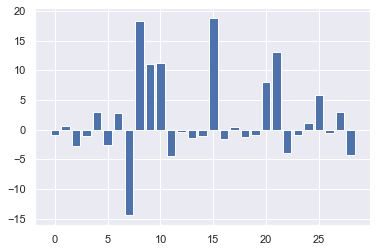

In [198]:
# linear regression for feature importance of data
from sklearn.datasets import make_classification
from sklearn.linear_model import LinearRegression
# define dataset
X=datastd.drop('Price',axis=1)
y=data["Price"] 
# define the model
model = LinearRegression()
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_
# summarize feature importance
column = datastd.columns
for i,v in enumerate(importance):
	print(str(column[i]) + ' [%0d], Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Al realizar el análisis del conjunto de datos, observamos que casi todas las variables tienen una alta influencia en la variable objetivo a predecir, "Price". Sin embargo, podemos destacar algunas variables que sobresalen sobre el resto: "Room Type", "Accommodates", "Bathrooms", "Bedrooms", "Cleaning Fee" y "Availability 30". Esto es interesante, ya que indica que a las personas les importa principalmente el tipo de propiedad y habitación que están alquilando, así como el número de baños y las comodidades que se ofrecen, lo que influye directamente en el precio del alquiler.

Por otro lado, observamos que variables como "Host Response Rate" y "Host Since" no tienen una relación significativa con el precio del Airbnb. Esto sugiere que la disponibilidad del anfitrión no es un factor importante al establecer el precio del alquiler.

Sin embargo, notamos que la ciudad y el país donde se encuentra el Airbnb tienen poca influencia en su precio. Parece que no hay ciudades o países específicos que tengan un impacto notable en el precio (al menos en los datos de este conjunto). Esto puede tener sentido ya que en esta base de datos, todas las ciudades representadas son igualmente importantes, por lo que no debería haber diferencias significativas entre ellas en términos de precio.

Por último, observamos algo sorprendente. Las variables relacionadas con las reseñas, como "Review Scores Rating", "Number of Reviews" y "Reviews per Month", no tienen tanta importancia en el precio de alquiler como cabría esperar. Parece que la gente no considera las reseñas de otros usuarios como un factor determinante al tomar decisiones de alquiler. Esto es realmente interesante y digno de estudio.

## 5. Métricas

Con el fin de realizar una clasificación adecuada de los modelos de predicción, vamos a definir algunas funciones que nos permitirán medir el rendimiento de cada algoritmo y compararlos entre sí. Dado que la variable a predecir es continua, utilizaremos métricas como el error cuadrático medio y el coeficiente de determinación (R2 score).

Además, crearemos cuatro funciones que calcularán el porcentaje de aciertos con un margen de 5€, 10€, 20€ y 40€, respectivamente. Estas funciones nos ayudarán a evaluar la precisión del modelo en términos de la proximidad del precio predicho al precio real del Airbnb.

Por último, también calcularemos la medida de precisión exacta, es decir, el porcentaje de veces que el modelo acierta el precio EXACTO del Airbnb. Debemos tener en cuenta que debido a la dificultad de esta métrica, es poco probable que su valor sea muy alto.

In [199]:
from sklearn.metrics import mean_squared_error, r2_score

def acc(test, predicciones):
    test_rounded = list(np.round(test))
    acc = np.mean(test_rounded == predicciones)*100
    return np.round(acc, 3)

def acc_5(test, predicciones):
    acc = []
    j = 0
    for i in y_data_test:
        interval = [i]
        for n in range(1,5):
            interval.append(i-n)
            interval.append(i+n)
        acc.append(interval.__contains__(np.round(predicciones[j])))
        j = j + 1
    return np.round(np.mean(acc)*100, 3)

def acc_10(test, predicciones):
    acc = []
    j = 0
    for i in y_data_test:
        interval = [i]
        for n in range(1,10):
            interval.append(i-n)
            interval.append(i+n)
        acc.append(interval.__contains__(np.round(predicciones[j])))
        j = j + 1
    return np.round(np.mean(acc)*100, 3)

def acc_20(test, predicciones):
    acc = []
    j = 0
    for i in y_data_test:
        interval = [i]
        for n in range(1,20):
            interval.append(i-n)
            interval.append(i+n)
        acc.append(interval.__contains__(np.round(predicciones[j])))
        j = j + 1
    return np.round(np.mean(acc)*100, 3)

def acc_40(test, predicciones):
    acc = []
    j = 0
    for i in y_data_test:
        interval = [i]
        for n in range(1,40):
            interval.append(i-n)
            interval.append(i+n)
        acc.append(interval.__contains__(np.round(predicciones[j])))
        j = j + 1
    return np.round(np.mean(acc)*100, 3)

In [201]:
#agrupamos en dos funciones:

def metricas(test, pred):
    # Error Absoluto Medio
    print("Mean Absolute Error", metrics.mean_absolute_error(test, pred))
    # Error Cuadrado Medio
    print("Mean squared error:", metrics.mean_squared_error(test, pred))
    print("Root Mean squared error:", np.sqrt(metrics.mean_squared_error(test, pred)))
    # Evaluamos el puntaje de varianza (siendo 1.0 el mejor posible)
    print('Variance score: %.2f' % r2_score(test, pred))
    
def acc_funct(test,pred):
    print('Acertamos exactamente el', acc(test, pred),'% de las predicciones.')
    print('Acertamos con un margen de 5€ el', acc_5(test, pred),'% de las predicciones.')
    print('Acertamos con un margen de 10€ el', acc_10(test, pred),'% de las predicciones.')
    print('Acertamos con un margen de 20€ el', acc_20(test, pred),'% de las predicciones.')
    print('Acertamos con un margen de 40€ el', acc_40(test, pred),'% de las predicciones.')

## 6. Modelos de predicción.

### 1. Regresión lineal

Comencemos la introducción a los modelos de predicción con uno de los más sencillos pero que ofrece resultados bastante decentes: la regresión lineal. Dado que nuestra variable objetivo, "Price", es continua, creemos que la regresión lineal puede proporcionar resultados interesantes. Incluso podría ser más adecuada que la regresión logística, que se utiliza para variables binarias. Sin embargo, exploraremos esto con más detalle más adelante.

#### Regresión Lineal Simple (1 variable)

In [203]:
# Importamos las librerias que vamos a usar
from sklearn import linear_model
from sklearn import metrics

# Creamos el objeto de Regresión Linear
regr = linear_model.LinearRegression()

# Entrenamos nuestro modelo
regr.fit(X_data['Cleaning Fee'].values.reshape(-1, 1), y_data)

# Hacemos las predicciones que en definitiva una línea (en este caso, al ser 2D)
y_pred=regr.predict(X_data_test['Cleaning Fee'].values.reshape(-1, 1))

# Veamos los coeficienetes obtenidos, En nuestro caso, serán la Tangente
print('Coefficients: \n', regr.coef_)
# Este es el valor donde corta el eje Y (en X=0)
print('Independent term: \n', regr.intercept_)

metricas(y_data_test, y_pred)

acc_funct(y_data_test, y_pred)

Coefficients: 
 [1.17624463]
Independent term: 
 51.599058964490396
Mean Absolute Error 36.04981482635154
Mean squared error: 4001.8522754177893
Root Mean squared error: 63.26019503145552
Variance score: 0.19
Acertamos exactamente el 0.0 % de las predicciones.
Acertamos con un margen de 5€ el 7.644 % de las predicciones.
Acertamos con un margen de 10€ el 16.486 % de las predicciones.
Acertamos con un margen de 20€ el 35.866 % de las predicciones.
Acertamos con un margen de 40€ el 76.979 % de las predicciones.


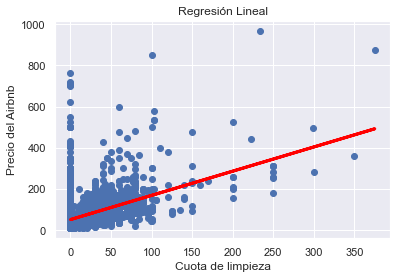

In [204]:
plt.scatter(X_data_test['Cleaning Fee'], y_data_test)
plt.plot(X_data_test['Cleaning Fee'], y_pred, color='red', linewidth=3)

plt.xlabel('Cuota de limpieza')
plt.ylabel('Precio del Airbnb')
plt.title('Regresión Lineal')

plt.show()

Nos da unos resultados muy malos, pues estamos utilizando una sóla variable para predecir. Hagamos esto mismo utilizando todas las variables.

#### Regresión lineal múltiple

In [205]:
# Creamos un nuevo objeto de Regresión Lineal
regr2 = linear_model.LinearRegression()

# Entrenamos el modelo, esta vez, con 30 dimensiones
# obtendremos 30 coeficientes, lo que nos hace imposible graficar nada
regr2.fit(X_data, y_data)

# Hacemos la predicción con la que tendremos puntos sobre el plano hallado
t_pred = regr2.predict(X_data_test)

# Los coeficientes
print('Coefficients: \n', regr2.coef_)
metricas(y_data_test, t_pred)

acc_funct(y_data_test, t_pred)

Coefficients: 
 [-2.60675921e-03  1.20977513e+00 -1.04133277e-01 -7.53085881e-01
  1.93724137e-01 -1.56291770e+00  4.79848533e-01 -2.78487604e+01
  8.17938012e+00  1.72119810e+01  1.35693426e+01 -2.43412939e+00
 -4.57892812e+00 -2.98912092e-01 -9.95863067e-03  6.90950081e-01
 -1.26794510e+00  1.06593827e-01 -2.11951343e-01 -1.25230003e-03
  3.88414800e-02  1.42714091e+00 -1.30100267e-01 -6.64157008e-03
  4.40915338e-02  7.90706233e-01 -1.09825805e+00  1.15176294e-01
 -2.64053504e+00]
Mean Absolute Error 28.629526939961362
Mean squared error: 2730.3442072977787
Root Mean squared error: 52.25269569407667
Variance score: 0.45
Acertamos exactamente el 0.0 % de las predicciones.
Acertamos con un margen de 5€ el 13.275 % de las predicciones.
Acertamos con un margen de 10€ el 28.81 % de las predicciones.
Acertamos con un margen de 20€ el 52.216 % de las predicciones.
Acertamos con un margen de 40€ el 80.077 % de las predicciones.


Tenemos un variance score de 0.45, bastante bueno. 
Vamos a ver cuánto mejoramos en comparación con 1 variable 

In [206]:
mejoraEnError = mean_squared_error(y_data_test, y_pred) - mean_squared_error(y_data_test, t_pred)
print(mejoraEnError)

1271.5080681200106


In [207]:
mejoraEnVarianza = r2_score(y_data_test, t_pred) - r2_score(y_data_test, y_pred)
print(mejoraEnVarianza)

0.25684212898536707


Hemos logrado reducir el error en aproximadamente 1271 unidades y la varianza en casi un 26%. Esto representa una mejora significativa en comparación con el primer modelo, el cual era claramente deficiente. Los resultados obtenidos son realmente malos

Crearemos un dataframe en el que registraremos todas las predicciones realizadas con cada uno de los modelos. Esto nos permitirá tener una forma sencilla de visualizar y analizar todo lo que hemos hecho hasta ahora, y así poder pasar al siguiente modelo de manera organizada.

In [208]:
predicciones = pd.DataFrame({'Real Price':y_data_test, 'Linear Regression':t_pred})

In [209]:
predicciones.head(10)

,Real Price,Linear Regression
1136,50.0,102.964606
10957,45.0,87.498803
1884,110.0,124.736217
7724,70.0,47.539334
13178,49.0,77.317459
12663,55.0,67.674578
681,105.0,47.425280
9167,80.0,77.110246
10225,17.0,33.094569
5591,115.0,132.562207


#### Regresión lineal múltiple con las variables importantes para el modelo

In [210]:
# Creamos un nuevo objeto de Regresión Lineal
regr3 = linear_model.LinearRegression()

X_data3 = X_data.loc[:,['Room Type','Accommodates','Bathrooms', 'Bedrooms', 'Beds', 'Cleaning Fee',
                           'Calendar Updated', 'Availability 30', 'Review Scores Rating',]]

X_data_test3 = X_data_test.loc[:,['Room Type','Accommodates','Bathrooms', 'Bedrooms', 'Beds', 'Cleaning Fee',
                           'Calendar Updated', 'Availability 30', 'Review Scores Rating',]]

regr3.fit(X_data3, y_data)

# Hacemos la predicción con la que tendremos puntos sobre el plano hallado
t_pred3 = regr3.predict(X_data_test3)

# Los coeficientes
print('Coefficients: \n', regr3.coef_)
metricas(y_data_test, t_pred3)

acc_funct(y_data_test, t_pred3)

Coefficients: 
 [-26.01022931   7.39232435  18.83745594  14.28071025  -2.32857968
   0.66679525   0.05192898   1.14810518   0.6807152 ]
Mean Absolute Error 28.046305988700365
Mean squared error: 2760.812633005113
Root Mean squared error: 52.5434356794939
Variance score: 0.44
Acertamos exactamente el 0.0 % de las predicciones.
Acertamos con un margen de 5€ el 14.45 % de las predicciones.
Acertamos con un margen de 10€ el 28.969 % de las predicciones.
Acertamos con un margen de 20€ el 54.568 % de las predicciones.
Acertamos con un margen de 40€ el 81.434 % de las predicciones.


Se puede observar cómo las predicciones son ligeramente mejores, a la vez que disminuye ligeramente el error de predicción. Sin embargo, la variance score disminuye (de 0.45 a 0.44). 

In [211]:
predicciones = pd.DataFrame({'Real Price':y_data_test, 'Linear Regression':t_pred, 'Specific Linear Regression':t_pred3})

In [212]:
predicciones.head(10)

,Real Price,Linear Regression,Specific Linear Regression
1136,50.0,102.964606,95.322079
10957,45.0,87.498803,86.112427
1884,110.0,124.736217,115.876109
7724,70.0,47.539334,50.062734
13178,49.0,77.317459,62.359326
12663,55.0,67.674578,55.293760
681,105.0,47.425280,49.150530
9167,80.0,77.110246,69.886211
10225,17.0,33.094569,16.125375
5591,115.0,132.562207,145.122386


Podemos observar que el último modelo es el que mejores predicciones hace 

### 2. SVM en regresión

La regresión de vectores de soporte (SVR) es una variante de la máquina de vectores de soporte (SVM) utilizada para la regresión. Las SVM tienen las siguientes aplicaciones:

- Pueden ser utilizadas para realizar regresiones o clasificaciones en conjuntos de datos de alta dimensionalidad.
- Mediante el parámetro del kernel, las SVM son capaces de aplicar regresiones y clasificaciones en conjuntos de datos no lineales.
- Los algoritmos SVM se utilizan comúnmente para la clasificación ordinal o la regresión, lo que los convierte en algoritmos populares en problemas de clasificación.

Por lo tanto, vamos a explorar qué tan bien funciona la SVR para predecir los precios de nuestro conjunto de datos, utilizando diferentes kernels, ya que no estamos seguros de cuál se ajustará mejor a nuestros datos.

#### Kernel 'linear'

In [213]:
from sklearn.svm import SVR

# definimos modelo
svr = SVR(kernel='linear', C=1, gamma='scale').fit(X_datastd,y_datastd)

# predicción
svr_pred = svr.predict(X_datastd_test)

In [214]:
metricas(y_datastd_test, svr_pred)
acc_funct(y_datastd_test, svr_pred)

Mean Absolute Error 24.925306466091754
Mean squared error: 2988.429202027286
Root Mean squared error: 54.66652725413684
Variance score: 0.40
Acertamos exactamente el 0.0 % de las predicciones.
Acertamos con un margen de 5€ el 18.951 % de las predicciones.
Acertamos con un margen de 10€ el 38.783 % de las predicciones.
Acertamos con un margen de 20€ el 65.287 % de las predicciones.
Acertamos con un margen de 40€ el 86.07 % de las predicciones.


La precisión al aplicar el kernel lineal en este método resulta ser muy buena, incluso mejor que en la regresión lineal simple y múltiple. La varianza obtenida es de 0.40, lo cual es positivo, aunque menor que en los dos métodos anteriores.

Ahora vamos a explorar cómo estos valores cambian al utilizar diferentes kernels en el método de regresión de vectores de soporte.

#### Kernel 'poly'

In [215]:
# definimos modelo
svr = SVR(kernel='poly', C=1, gamma='scale').fit(X_datastd,y_datastd)

# predicción
svr_pred = svr.predict(X_datastd_test)

In [217]:
metricas(y_datastd_test, svr_pred)
acc_funct(y_datastd_test, svr_pred)

Mean Absolute Error 25.618905077546113
Mean squared error: 2613.922264755223
Root Mean squared error: 51.12653190619547
Variance score: 0.47
Acertamos exactamente el 0.0 % de las predicciones.
Acertamos con un margen de 5€ el 16.327 % de las predicciones.
Acertamos con un margen de 10€ el 33.243 % de las predicciones.
Acertamos con un margen de 20€ el 61.963 % de las predicciones.
Acertamos con un margen de 40€ el 85.346 % de las predicciones.


Podemos observar que aunque acierte menos, la variabilidad es menor también

#### Kernel 'rbf'

In [219]:
# definimos modelo
svr = SVR(kernel='rbf', C=1, gamma='scale').fit(X_datastd,y_datastd)

# predicción
svr_pred = svr.predict(X_datastd_test)

In [221]:
metricas(y_datastd_test, svr_pred)
acc_funct(y_datastd_test, svr_pred)

Mean Absolute Error 25.77574370416322
Mean squared error: 3535.1280614392776
Root Mean squared error: 59.456942920396415
Variance score: 0.29
Acertamos exactamente el 0.0 % de las predicciones.
Acertamos con un margen de 5€ el 20.421 % de las predicciones.
Acertamos con un margen de 10€ el 40.231 % de las predicciones.
Acertamos con un margen de 20€ el 66.983 % de las predicciones.
Acertamos con un margen de 40€ el 86.251 % de las predicciones.


Al observar los resultados, notamos que el kernel 'rbf' es el que proporciona las mejores predicciones, especialmente con un margen de 5 euros (20.421% de aciertos). Sin embargo, también es el kernel que muestra la mayor variabilidad, con un valor de varianza muy bajo (0.29), lo cual no es positivo. Además, el error en este caso tiende a aumentar en comparación con los otros kernels evaluados.

Al evaluar los resultados obtenidos con los diferentes kernels, si tuviéramos que elegir uno para predecir los precios, optaríamos por el kernel 'rbf'. Aunque no es el mejor en todas las métricas, es el que ofrece mejores resultados al predecir precios en un rango pequeño (20.421% con un margen de 5 euros). Por lo tanto, vamos a agregar las predicciones generadas con el kernel 'rbf' a nuestro dataframe de predicciones.

En resumen, a pesar de que los resultados no son perfectos, observamos una mejora general en comparación con la regresión lineal simple y múltiple. Por lo tanto, consideramos que este método es más adecuado que el anterior para predecir los precios.

In [222]:
predicciones['svr']=svr_pred
predicciones.head(10)

,Real Price,Linear Regression,Specific Linear Regression,svr
1136,50.0,102.964606,95.322079,58.705844
10957,45.0,87.498803,86.112427,64.675775
1884,110.0,124.736217,115.876109,98.819316
7724,70.0,47.539334,50.062734,51.513012
13178,49.0,77.317459,62.359326,67.554628
12663,55.0,67.674578,55.293760,41.299667
681,105.0,47.425280,49.150530,84.668192
9167,80.0,77.110246,69.886211,72.097735
10225,17.0,33.094569,16.125375,40.425406
5591,115.0,132.562207,145.122386,108.819543


### 4. Árboles de regresión

Los árboles de decisión son comúnmente utilizados en problemas de clasificación, donde la variable objetivo es cualitativa. Sin embargo, en nuestro caso, al tener una variable objetivo cuantitativa, podemos utilizar árboles de regresión. Estos árboles se construyen haciendo preguntas del tipo "¿x ≤ c?" para cada una de las variables predictoras. De esta manera, el espacio de las variables predictoras se divide en hiper-rectángulos, y todas las observaciones que se encuentren dentro de un hiper-rectángulo tendrán el mismo valor estimado para la variable objetivo.

In [226]:
from sklearn.tree import DecisionTreeRegressor
regTree = DecisionTreeRegressor(max_depth=9)
regTree.fit(X_data,y_data)

regTree_pred = regTree.predict(X_data_test)

In [227]:
metricas(y_data_test, regTree_pred)

acc_funct(y_data_test, regTree_pred)

Mean Absolute Error 24.084431962446512
Mean squared error: 2440.61816448096
Root Mean squared error: 49.40261293171607
Variance score: 0.51
Acertamos exactamente el 0.023 % de las predicciones.
Acertamos con un margen de 5€ el 19.177 % de las predicciones.
Acertamos con un margen de 10€ el 38.58 % de las predicciones.
Acertamos con un margen de 20€ el 64.858 % de las predicciones.
Acertamos con un margen de 40€ el 85.572 % de las predicciones.


Resulta llamativo que logramos acertar exactamente el 0.113% de las predicciones, aunque es un porcentaje muy pequeño. Ninguno de los métodos anteriores había logrado acertar los precios exactamente. Además, observamos que el nivel de varianza (variance score) es muy alto, con un valor de 0.52, el mejor hasta ahora en comparación con los otros métodos.

En base a estos resultados, hasta el momento, este sería el método que elegiríamos para predecir, ya que ha obtenido los mejores resultados en general en términos de varianza, precisión, entre otros.

In [228]:
predicciones['regTree']=regTree_pred
predicciones.head(10)

,Real Price,Linear Regression,Specific Linear Regression,svr,regTree
1136,50.0,102.964606,95.322079,58.705844,77.840593
10957,45.0,87.498803,86.112427,64.675775,77.840593
1884,110.0,124.736217,115.876109,98.819316,111.575163
7724,70.0,47.539334,50.062734,51.513012,58.604669
13178,49.0,77.317459,62.359326,67.554628,77.840593
12663,55.0,67.674578,55.293760,41.299667,33.700000
681,105.0,47.425280,49.150530,84.668192,126.533333
9167,80.0,77.110246,69.886211,72.097735,77.840593
10225,17.0,33.094569,16.125375,40.425406,31.093797
5591,115.0,132.562207,145.122386,108.819543,148.852459


### 5. XGBOOST

El XGBoost es una forma de usar Gradient Boosting que saca el máximo partido de los árboles de decisión individuales. A diferencia de los otros métodos, los árboles se construyen en paralelo en vez de en profundidad.

El algoritmo funciona de la siguiente forma:
    - Se crea un árbol inicial para predecir la variable objetivo y se crea un árbol 'residual' (con el error)
    - Se calcula un nuevo árbol que ajusta el error anterior
    - Este nuevo árbol y el inicial se combinan para crear otro nuevo (con menor error que el inicial)
    - El proceso se sigue iterativamente hasta que el error es minimizado lo más posible

Las principales ventajas que tiene es que da resultados muy precisos y a gran velocidad, además que permite trabajar con muchas variables y, aunque en este caso no es necesario, con missing.



In [ ]:
#pip install xgboost
from xgboost import XGBRegressor
import xgboost as xgb

In [ ]:
model = XGBRegressor(booster= 'gbtree', learning_rate= 0.1, max_depth= 5, subsample=1)
model.fit(X_data, y_data)

In [ ]:
#RESULTADO DE model.fit(X_data, y_data)
#XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
#             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
#             early_stopping_rounds=None, enable_categorical=False,
#             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
#             importance_type=None, interaction_constraints='',
#             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
#             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
#             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
#             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
#             reg_lambda=1, ...)

In [ ]:
# En funcion de los parametros que hemos puesto podemos ver que variables tienen mayor importancia 

import matplotlib.pyplot as plt
%matplotlib inline

xgb.plot_importance(model, ax = plt.gca())

In [ ]:
xgb_pred = model.predict(X_data_test)


In [ ]:
metricas(y_data_test, xgb_pred)

acc_funct(y_data_test, xgb_pred)

In [ ]:
#Mean Absolute Error 19.466265453681963
#Mean squared error: 1414.57102805847
#Root Mean squared error: 37.610783401286255
#Variance score: 0.71
#Acertamos exactamente el 0.0 % de las predicciones.
#Acertamos con un margen de 5€ el 22.84 % de las predicciones.
#Acertamos con un margen de 10€ el 44.867 % de las predicciones.
#Acertamos con un margen de 20€ el 70.896 % de las predicciones.
#Acertamos con un margen de 40€ el 89.711 % de las predicciones.

Como podemos observar nos da super buenos resultados, de hecho el mejor hasta ahora

In [ ]:
#añadimos el modelo 
predicciones['XGB']=xgb_pred
predicciones.head(10)

## 7. Conclusiones

Hemos llevado a cabo un estudio y aplicación de diversos algoritmos de predicción que se discutieron en clase. 

En relación a los resultados obtenidos en este conjunto de datos específico, podemos ordenar los algoritmos de mejor a peor rendimiento de la siguiente manera:

1. XGBoost
2. Árbol de regresión
3. Red neuronal
4. SVR con kernel rbf
5. SVR con kernel polinomial
6. SVR con kernel lineal
7. Regresión múltiple
8. Regresión lineal

Estas conclusiones se basan en el análisis de las métricas creadas, los errores y los scores de varianza que hemos obtenido y evaluado a lo largo de este trabajo.

Todas las predicciones realizadas por cada método se pueden observar en el dataframe denominado 'predicciones'.

A continuación, muestro cómo se presenta la información finalmente:

In [ ]:
predicciones.head(20)